In [1]:
import os
import random

import pandas as pd
import numpy as np
import sklearn.metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import _gradient_boosting
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
# from helper_functions_pipe_testing import *
from sklearn.metrics import  f1_score, recall_score, precision_score, confusion_matrix
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
# from imblearn.over_sampling import *
from sklearn.preprocessing import LabelEncoder
from helper_functions_KP import *
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.linear_model import LogisticRegression
from scipy.stats import pearsonr
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score, precision_score, recall_score
import math

#Instructions for the pipeline Requires two inputs for training: - Mass spec data with corresponding NP surface characteristics and experimental conditions (time, concentration) - NetsurfP and Biopython data that has been precalculated - X characteristics to predict
pipeline Take mass spec spreadsheet Accession,Enrichment,Dh,TEM,Zp,BET,Composition,Ligand,Shape,IncubationTime,IncubationConcentration Merge with Proteome data to get file that has Accession,Enrichment,Dh,TEM,Zp,BET,Composition,Ligand,Shape,IncubationTime,IncubationConcentration,Mass,Length,Sequence Calculate protein features using biopython Merge with NSP data to get all protein features
Split into X and Y dataset with Entries as labels
In this pipeline (look at synth dataset and generate validation and prediction datasets out of original dataset)

In [8]:
#Sample code for loading saved DF and dropping appropriate columns before running### Also For running RFECV and saving the reduced df
df_filepath='Input_data/Save_files/df_2_Synth.xlsx'
id='04232023'
df = pd.read_excel(df_filepath, header=0)
to_drop = df.filter(like='total_exposed_')
df=df.drop(columns=to_drop.columns).copy()
df.to_excel("Input_data/Save_files/df_2_Synth.xlsx")
# labels_df= df['Abundance'].copy()
# id_col= df['NPUNID'].copy()
# label_abund=np.ravel(labels_df)
# model=RandomForestRegressor(n_estimators=100)
# splits=10
# scoring='neg_mean_squared_error'
# df=df.drop(columns=['Entry', 'Sequence', 'NPID', 'Ligands', 'Protein Source', 'Sample_num', 'Unnamed: 5','Raw_FileID'])
# import math
#
# start = 0.0001
# stop = 1
# num_points = 10
# # Calculate the common difference between consecutive terms in the series
# common_diff = (math.log(stop) - math.log(start)) / (num_points - 1)
# # Generate the logarithmic series as a list
# Abund_filter = [start * math.exp(i * common_diff) for i in range(num_points)]
# # model = RandomForestRegressor(n_estimators=80)
# # summary_tmp=[]
# for i in Abund_filter:
#     df_out= df[df['Abundance']>=i].copy()
# df = RFECV_plot(df,label_abund,model,id,folds=splits,step=2,scoring=scoring)

    # df_out.to_excel("Input_data/Save_files/Abund_Filters/df_1_all"+str(i)+".xlsx")


In [ ]:
## Run RFECV through each different condition (zeros and abund filters)##

in_dir='Input_data/Save_files/ZerosReduced/'
files=os.listdir(in_dir)
files
for file in files:
    filepath=in_dir+file
    id=file[:-10]
    # print(id)
    # print(filepath)
    df= pd.read_excel(filepath,header=0)
    labels_df= df['Abundance'].copy()
    id_col= df['NPUNID'].copy()
    label_abund=np.ravel(labels_df)
    model=RandomForestRegressor(n_estimators=100)
    splits=5
    df=df.drop(columns=['Entry', 'Abundance', 'Sequence', 'NPID', 'Ligands', 'Protein Source', 'Sample_num', 'Unnamed: 5','Raw_FileID','NPUNID','Abundance_Controls'])
    df = RFECV_plot(df,label_abund,model,id,folds=splits,step=2)
    df_out=pd.concat([df, id_col,labels_df], axis=1)
    df_out.to_excel(in_dir+id+'RFECV.xlsx',index=False)



In [25]:
##Run RFE and Scorer on each file in a given directory -- Outputs feat importance and score summaries for RFR##
in_dir='Input_data/Save_files/Abund_Filters/'
files=os.listdir(in_dir)

model=RandomForestRegressor(n_estimators=100)
# df_filepath='Input_data/Save_files/df_1_all.xlsx'

summary_tmp=[]
feats=[]
for file in files:
    filepath=in_dir+file
    df = pd.read_excel(filepath, header=0)
    identifier=file[:-5]
    labels_df= df['Abundance'].copy()
    id_col= df['NPUNID'].copy()
    label_abund=np.ravel(labels_df)
    label_abund=np.log2(label_abund)
    # df=df.drop(columns=['Entry', 'Abundance', 'Sequence', 'NPID', 'Ligands', 'Protein Source', 'Sample_num', 'Unnamed: 5','Raw_FileID','NPUNID','Abundance_Controls'])
    # df=df.drop(columns=['Entry', 'Abundance', 'Sequence', 'NPID', 'Ligands', 'Protein Source', 'Sample_num', 'Unnamed: 5','Raw_FileID','NPUNID'])
    df=df.drop(columns='Abundance_Controls')
    df=df.drop(columns=['Abundance','NPUNID','BatchID','Unnamed: 0'])
    step = 3
    selector = RFE(model, n_features_to_select=15, step=step)
    selector = selector.fit(df, label_abund)
    feat_list = selector.get_feature_names_out()
    df = df[feat_list].copy()
    model.fit(df,labels_df)
    tmp2,tmp3=scorer(df, label_abund, model, identifier, 10)
    summary_tmp.append(tmp2)
    feats.append(tmp3)
# lasso_feature_selection(df, label_abund, id)
summary=pd.concat(summary_tmp,axis=0)
feat_summary=feats[0]
for d in feats[1:]:
    feat_summary=feat_summary.merge(d, on='Features',how='outer')
feat_summary.to_excel('Output_data/Feats_AbundFilters_log2.xlsx', index=False)
summary.to_excel('Output_data/Scores_AbundFilters_log2.xlsx', index=False)
print('done')


Scorer ran successfully
Scorer ran successfully
Scorer ran successfully
Scorer ran successfully
Scorer ran successfully
Scorer ran successfully
Scorer ran successfully
Scorer ran successfully
Scorer ran successfully
Scorer ran successfully
done


In [5]:
summary=pd.concat(summary_tmp,axis=0)
feat_summary=feats[0]
for d in feats[1:]:
    feat_summary=feat_summary.merge(d, on='Features',how='outer')
feat_summary.to_excel('Output_data/Feats_Zeros_removed_CA.xlsx', index=False)
summary.to_excel('Output_data/Scores_Zeros_removed_CA.xlsx', index=False)

In [14]:
df_filepath='Input_data/Save_files/df_2_Synth.xlsx'
df_a = pd.read_excel(df_filepath, header=0)
Abund_filter=[0.00001,0.0001,0.01,.1,0.5,0.8]

# df_a = df_a[df_a['Abundance']>=Abund_filter].copy()
# labels_df= df_a['Abundance'].copy()
# id_col= df_a['NPUNID'].copy()
# label_abund=np.ravel(labels_df)
#
# label_abund=np.log2(label_abund)
model=RandomForestRegressor(n_estimators=100)
print('here')
# df_a=df_a.drop(columns=['Entry', 'Abundance', 'Sequence', 'NPID', 'Ligands', 'Protein Source', 'Sample_num', 'Unnamed: 5','Raw_FileID','NPUNID','Abundance_Controls'])
summary_tmp=[]
feats=[]
for i in Abund_filter:
    df = df_a[df_a['Abundance']>=i].copy()
    labels_df= df['Abundance'].copy()
    id_col= df['NPUNID'].copy()
    label_abund=np.ravel(labels_df)
    identifier=str(i)
    label_abund=np.log2(label_abund)
    df=df.drop(columns=['Entry', 'Abundance', 'Sequence', 'NPID', 'Ligands', 'Protein Source', 'Sample_num', 'Unnamed: 5','Raw_FileID','NPUNID','Abundance_Controls'])
    selector = RFE(model, n_features_to_select=50, step=3)
    # print('start')
    selector = selector.fit(df, label_abund)
    # print('fit complete')
    selector.support_
    ranking = selector.ranking_
    feat_list = selector.get_feature_names_out()
    df = df[feat_list]
    df=RFECV_plot(df,label_abund,model,identifier,5,1)
    tmp2,tmp3=scorer(df, label_abund, model, identifier, 10)
    summary_tmp.append(tmp2)
    feats.append(tmp3)
    # lasso_feature_selection(df, label_abund, id)
    summary=pd.concat(summary_tmp,axis=0)
feat_summary=feats[0]
for d in feats[1:]:
    feat_summary=feat_summary.merge(d, on='Features',how='outer')
feat_summary.to_excel('Output_data/Feats_Synth_log2.xlsx', index=False)
summary.to_excel('Output_data/Scores_Synth_log2.xlsx', index=False)
# df_out=pd.concat([df, id_col,labels_df],axis=1)
# df_out.to_excel("Input_data/Save_files/df_1_all_RFE50_RFR.xlsx",index=False)

here
Recursive Feature Elimination with Correlated Features ran successfully
Scorer ran successfully
Recursive Feature Elimination with Correlated Features ran successfully
Scorer ran successfully
Recursive Feature Elimination with Correlated Features ran successfully
Scorer ran successfully
Recursive Feature Elimination with Correlated Features ran successfully
Scorer ran successfully
Recursive Feature Elimination with Correlated Features ran successfully
Scorer ran successfully
Recursive Feature Elimination with Correlated Features ran successfully
Scorer ran successfully


In [26]:
### Running Binary Classification systems and seeing what abund threshold is the best for performance##

abund_thresh=[-2,-1,-0.5,0.25,0.5,0.75,1,2,3,4]
df_filepath='Input_data/Save_files/df_1_no0.xlsx'
df = pd.read_excel(df_filepath, header=0)
Min_Control=df['Abundance_Controls'].drop_duplicates().nsmallest(2).iloc[-1]
df['Abundance_Controls'].replace(0,Min_Control,inplace=True)
df['Enrich']= np.log2(df['Abundance']/df['Abundance_Controls'])
# df = df.replace(np.inf,10)
model=RandomForestClassifier()
# id='RFR_AFilter_'+str(i)+'NoCon'
# Create an empty pandas DataFrame to store the evaluation metrics
eval_df = pd.DataFrame(columns=['Abund Thresh', 'F1', 'AUROC', 'Accuracy', 'Precision', 'Recall'])
df=df.drop(columns=['Entry', 'Sequence', 'NPID', 'Ligands', 'Protein Source', 'Sample_num','Raw_FileID','BatchID'])
df=df.drop(columns=['Abundance_Controls','Abundance'])

# Iterate through multiple iterations of model training and testing
for i in abund_thresh:
    df_a=df.copy()
    df_a['binary_target']= df_a['Enrich'].apply(lambda t: 1 if t>=i else 0)
    labels_df = df_a['binary_target'].copy()
    # id_col= df_a['NPUNID'].copy()
    label_binary=np.ravel(labels_df)
    df_a=df_a.drop(columns=['NPUNID','binary_target','Enrich']).copy()

    step = 2
    RFE_Feats=20
    selector = RFE(model, n_features_to_select=RFE_Feats, step=step)
    selector = selector.fit(df_a, label_binary)
    selector.support_
    ranking = selector.ranking_
    feat_list = selector.get_feature_names_out()
    df_a = df_a[feat_list].copy()

    x_train, x_test, y_train, y_test = train_test_split(df_a, label_binary, test_size=0.3, random_state=42)
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    f1 = f1_score(y_test, y_pred)
    auroc = roc_auc_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)

    # Append a new row to the eval_df DataFrame with the evaluation metrics for this iteration
    eval_df = eval_df.append({'Abund Thresh': i,
                              'F1': f1,
                              'AUROC': auroc,
                              'Accuracy': accuracy,
                              'Precision': precision,
                              'Recall': recall}, ignore_index=True)

eval_df.to_excel('Output_data/AbundThresholdingRFC2.xlsx', index=False)



C:\Users\kmp95\AppData\Local\Temp\ipykernel_24100\2291417116.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  eval_df = eval_df.append({'Abund Thresh': i,
C:\Users\kmp95\AppData\Local\Temp\ipykernel_24100\2291417116.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  eval_df = eval_df.append({'Abund Thresh': i,
C:\Users\kmp95\AppData\Local\Temp\ipykernel_24100\2291417116.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  eval_df = eval_df.append({'Abund Thresh': i,
C:\Users\kmp95\AppData\Local\Temp\ipykernel_24100\2291417116.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  eval_df = eval_df.append({'Abund Thresh': i,
C:\Users

PermissionError: [Errno 13] Permission denied: 'Output_data/AbundThresholdingRFC2.xlsx'

In [ ]:
df_a = pd.read_excel(df_filepath, header=0)
# df=df_a[df_a['Abundance']>=0.01]
# df_a['Abundance']=np.log10(df_a['Abundance']+1)
df['Abundance']=np.log2(df['Abundance']+1)
plt.hist(df['Abundance'],bins=25)
plt.xlim(-2,2)
plt.show()

In [11]:
# df['NPUNID'].unique().tolist()
Min_Control=df['Abundance_Controls'].drop_duplicates().nsmallest(2).iloc[-1]
Min_Control

3.97818750745931e-05

In [12]:
1*10^-4

-10

(7562, 105)
y_train  (3349,)
X_test  (129, 93)
X_train  (3349, 93)
<built-in function id>
y_train  (3300,)
X_test  (178, 93)
X_train  (3300, 93)
<built-in function id>
y_train  (3271,)
X_test  (207, 93)
X_train  (3271, 93)
<built-in function id>
y_train  (3335,)
X_test  (143, 93)
X_train  (3335, 93)
<built-in function id>
y_train  (3343,)
X_test  (135, 93)
X_train  (3343, 93)
<built-in function id>
y_train  (3284,)
X_test  (194, 93)
X_train  (3284, 93)
<built-in function id>
y_train  (3306,)
X_test  (172, 93)
X_train  (3306, 93)
<built-in function id>
y_train  (3259,)
X_test  (219, 93)
X_train  (3259, 93)
<built-in function id>
y_train  (3274,)
X_test  (204, 93)
X_train  (3274, 93)
<built-in function id>
y_train  (3263,)
X_test  (215, 93)
X_train  (3263, 93)
<built-in function id>
y_train  (3287,)
X_test  (191, 93)
X_train  (3287, 93)
<built-in function id>
y_train  (3308,)
X_test  (170, 93)
X_train  (3308, 93)
<built-in function id>
y_train  (3288,)
X_test  (190, 93)
X_train  (3288, 9

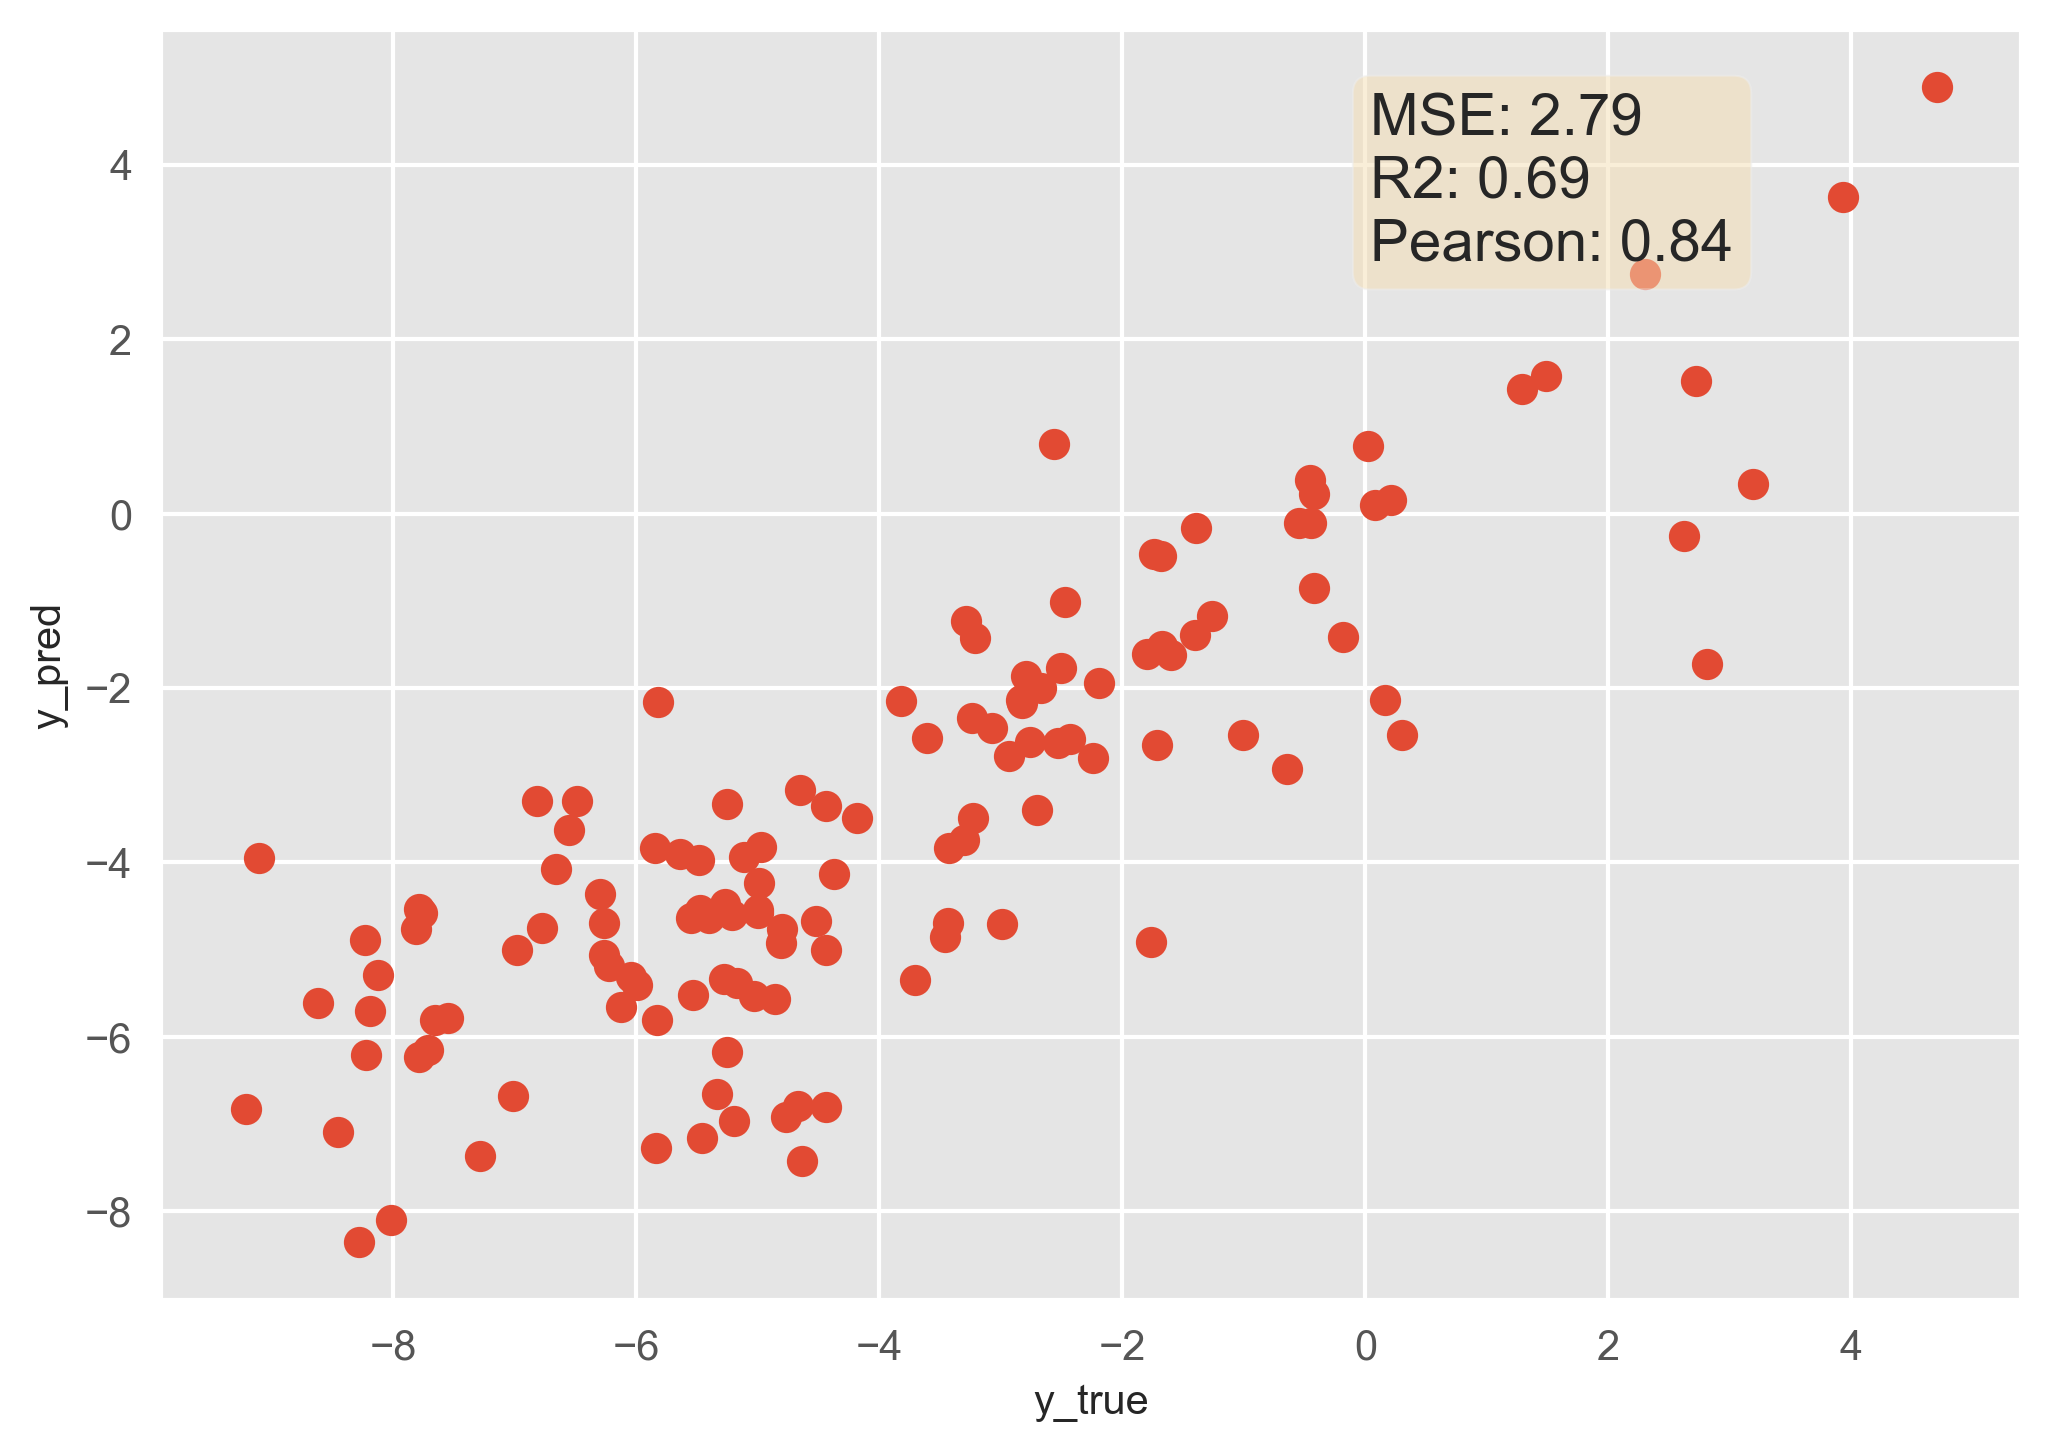

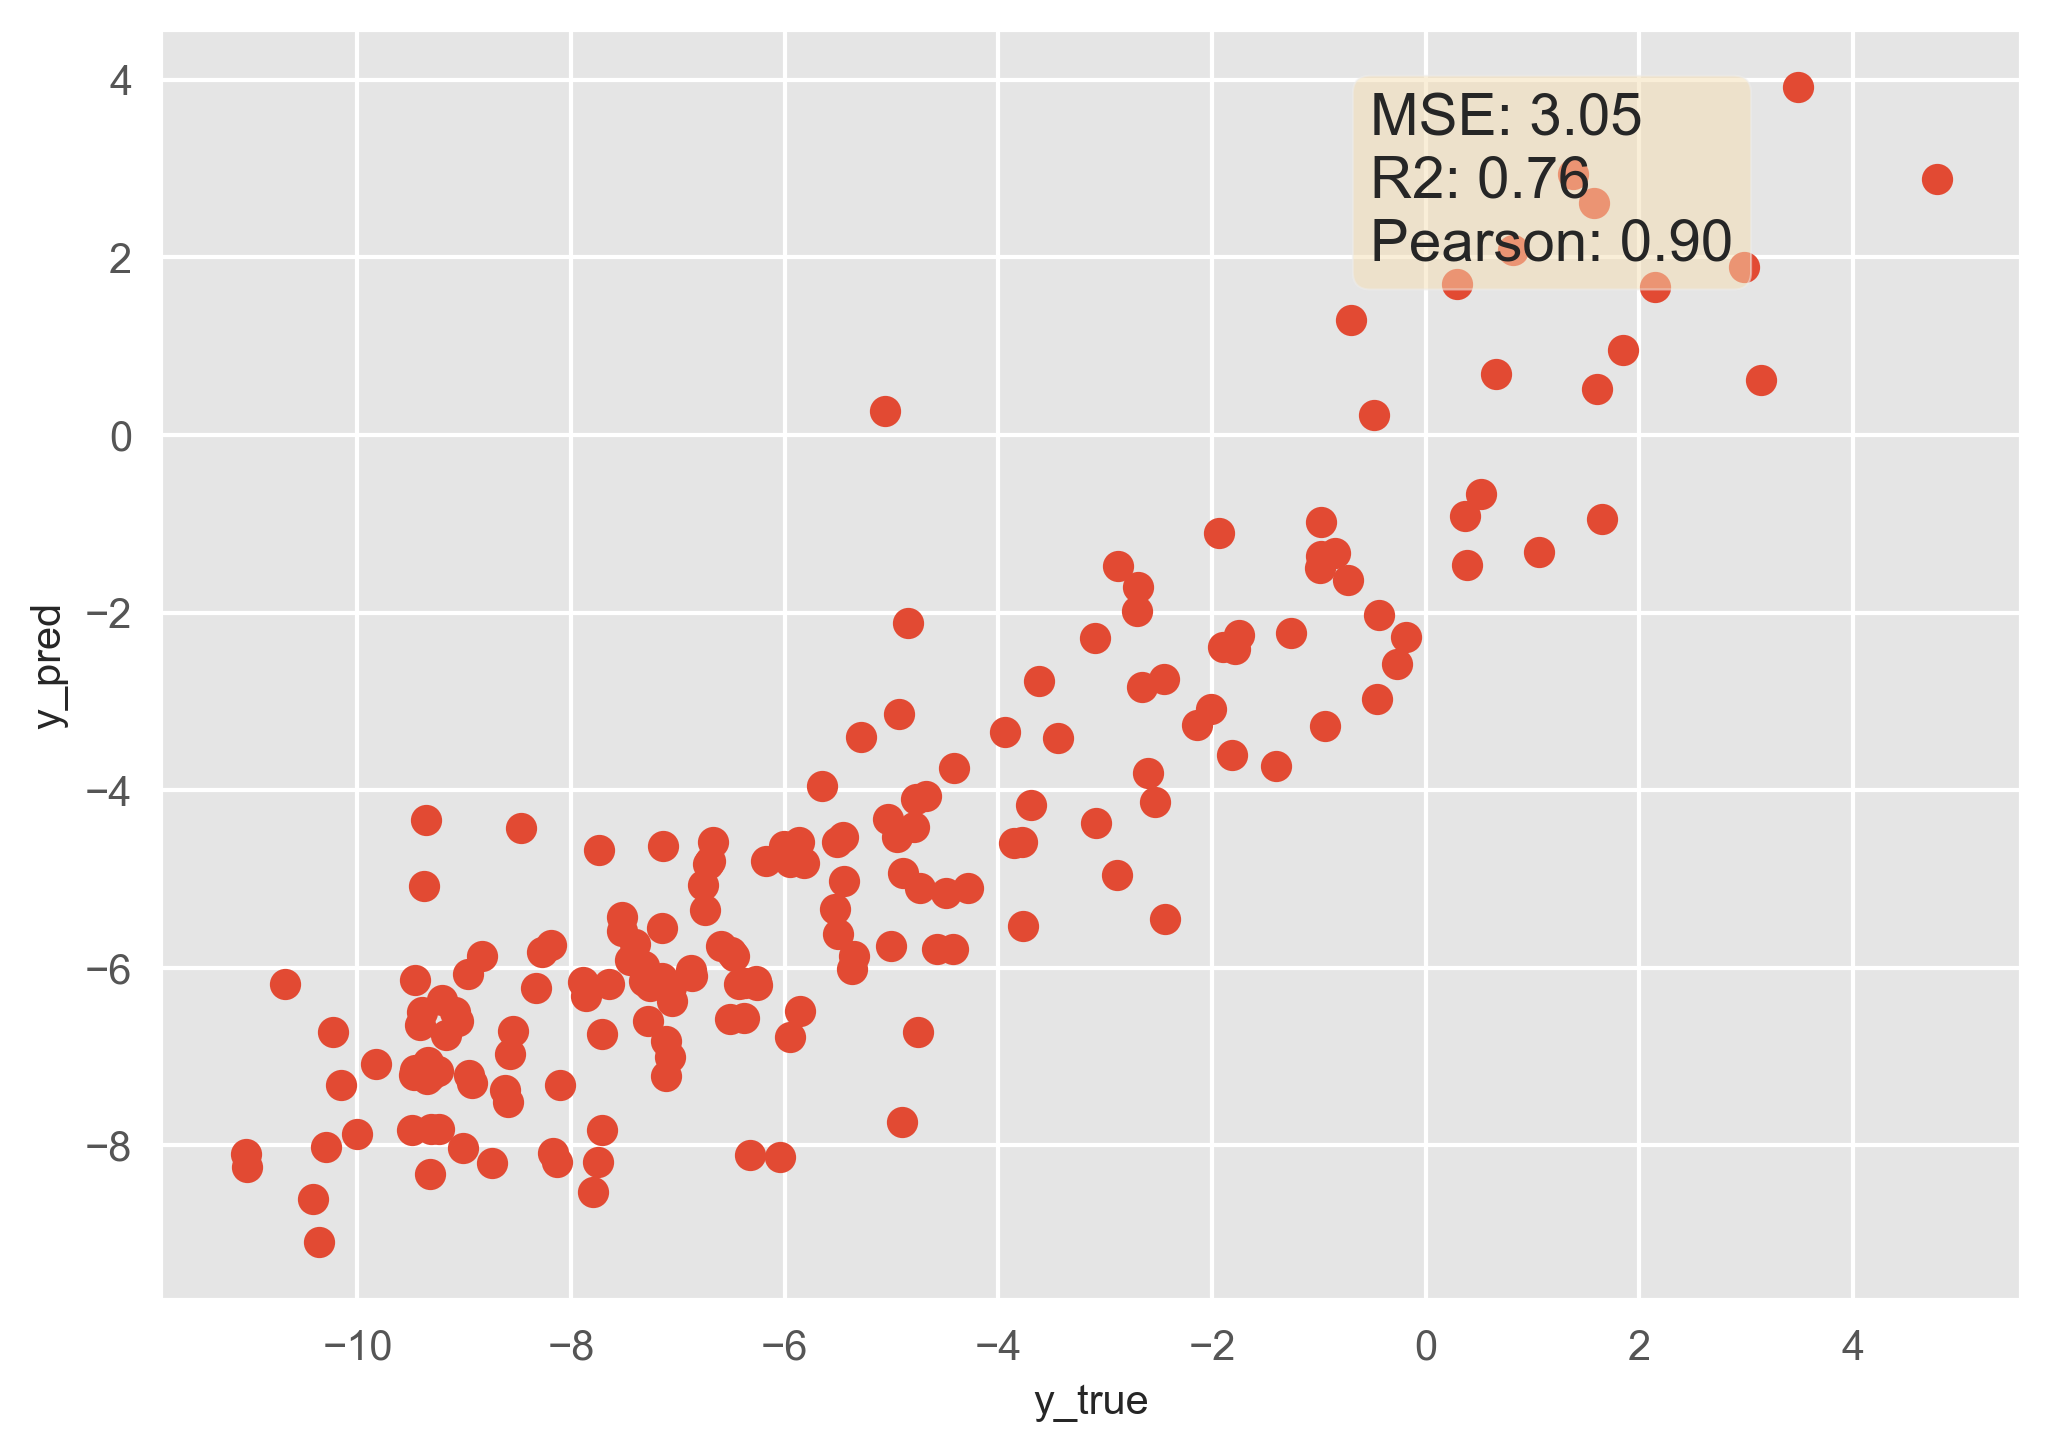

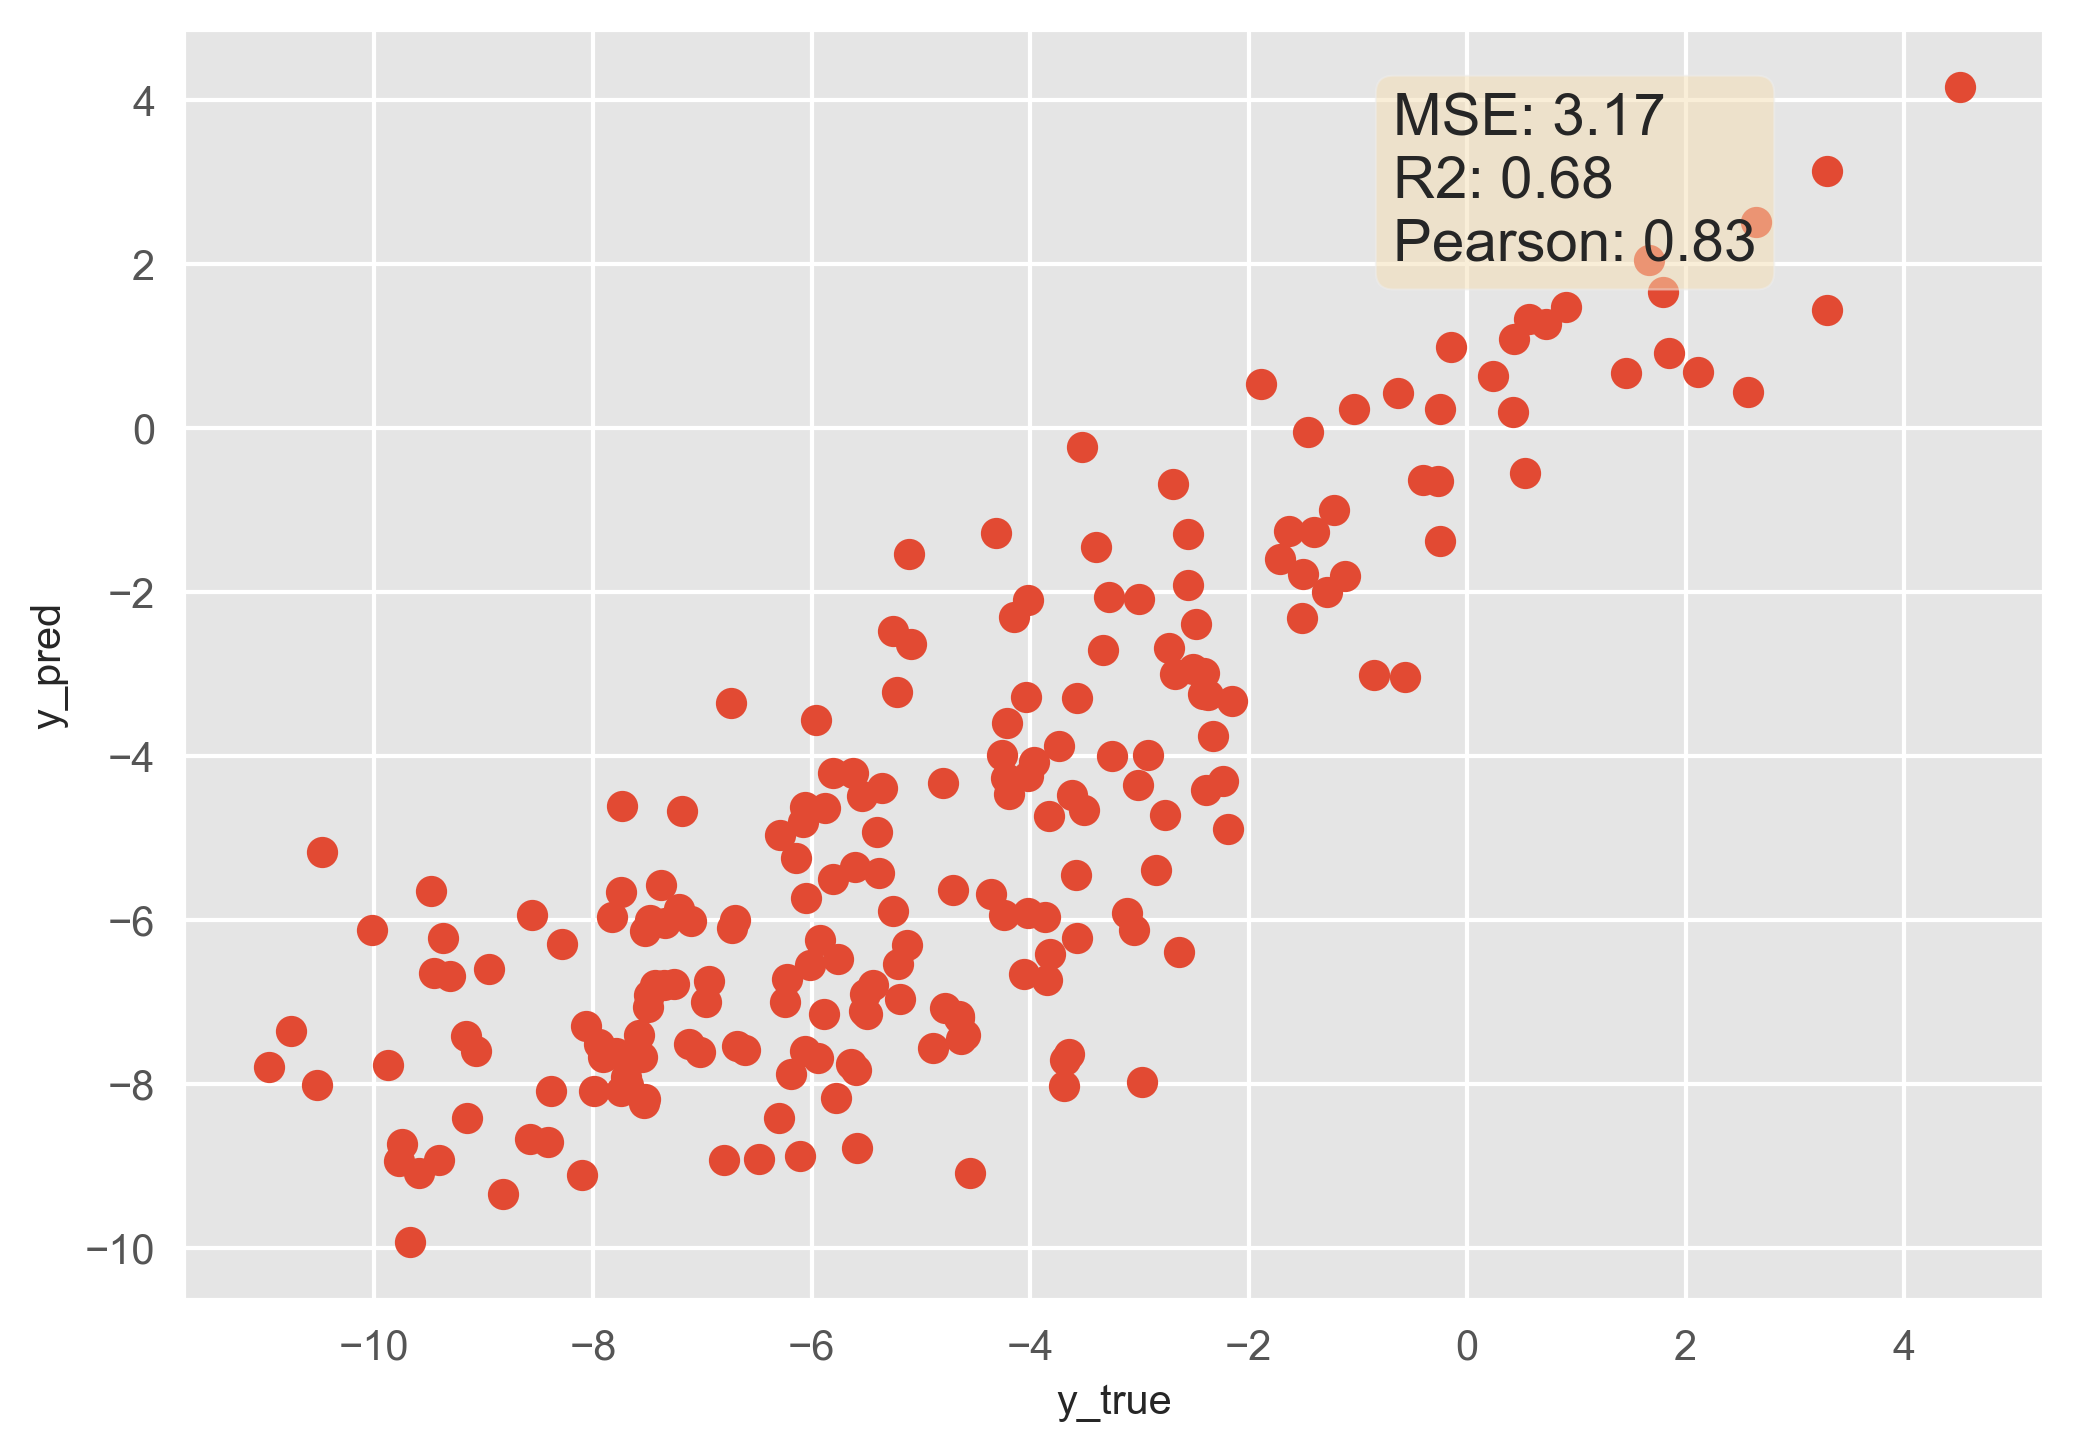

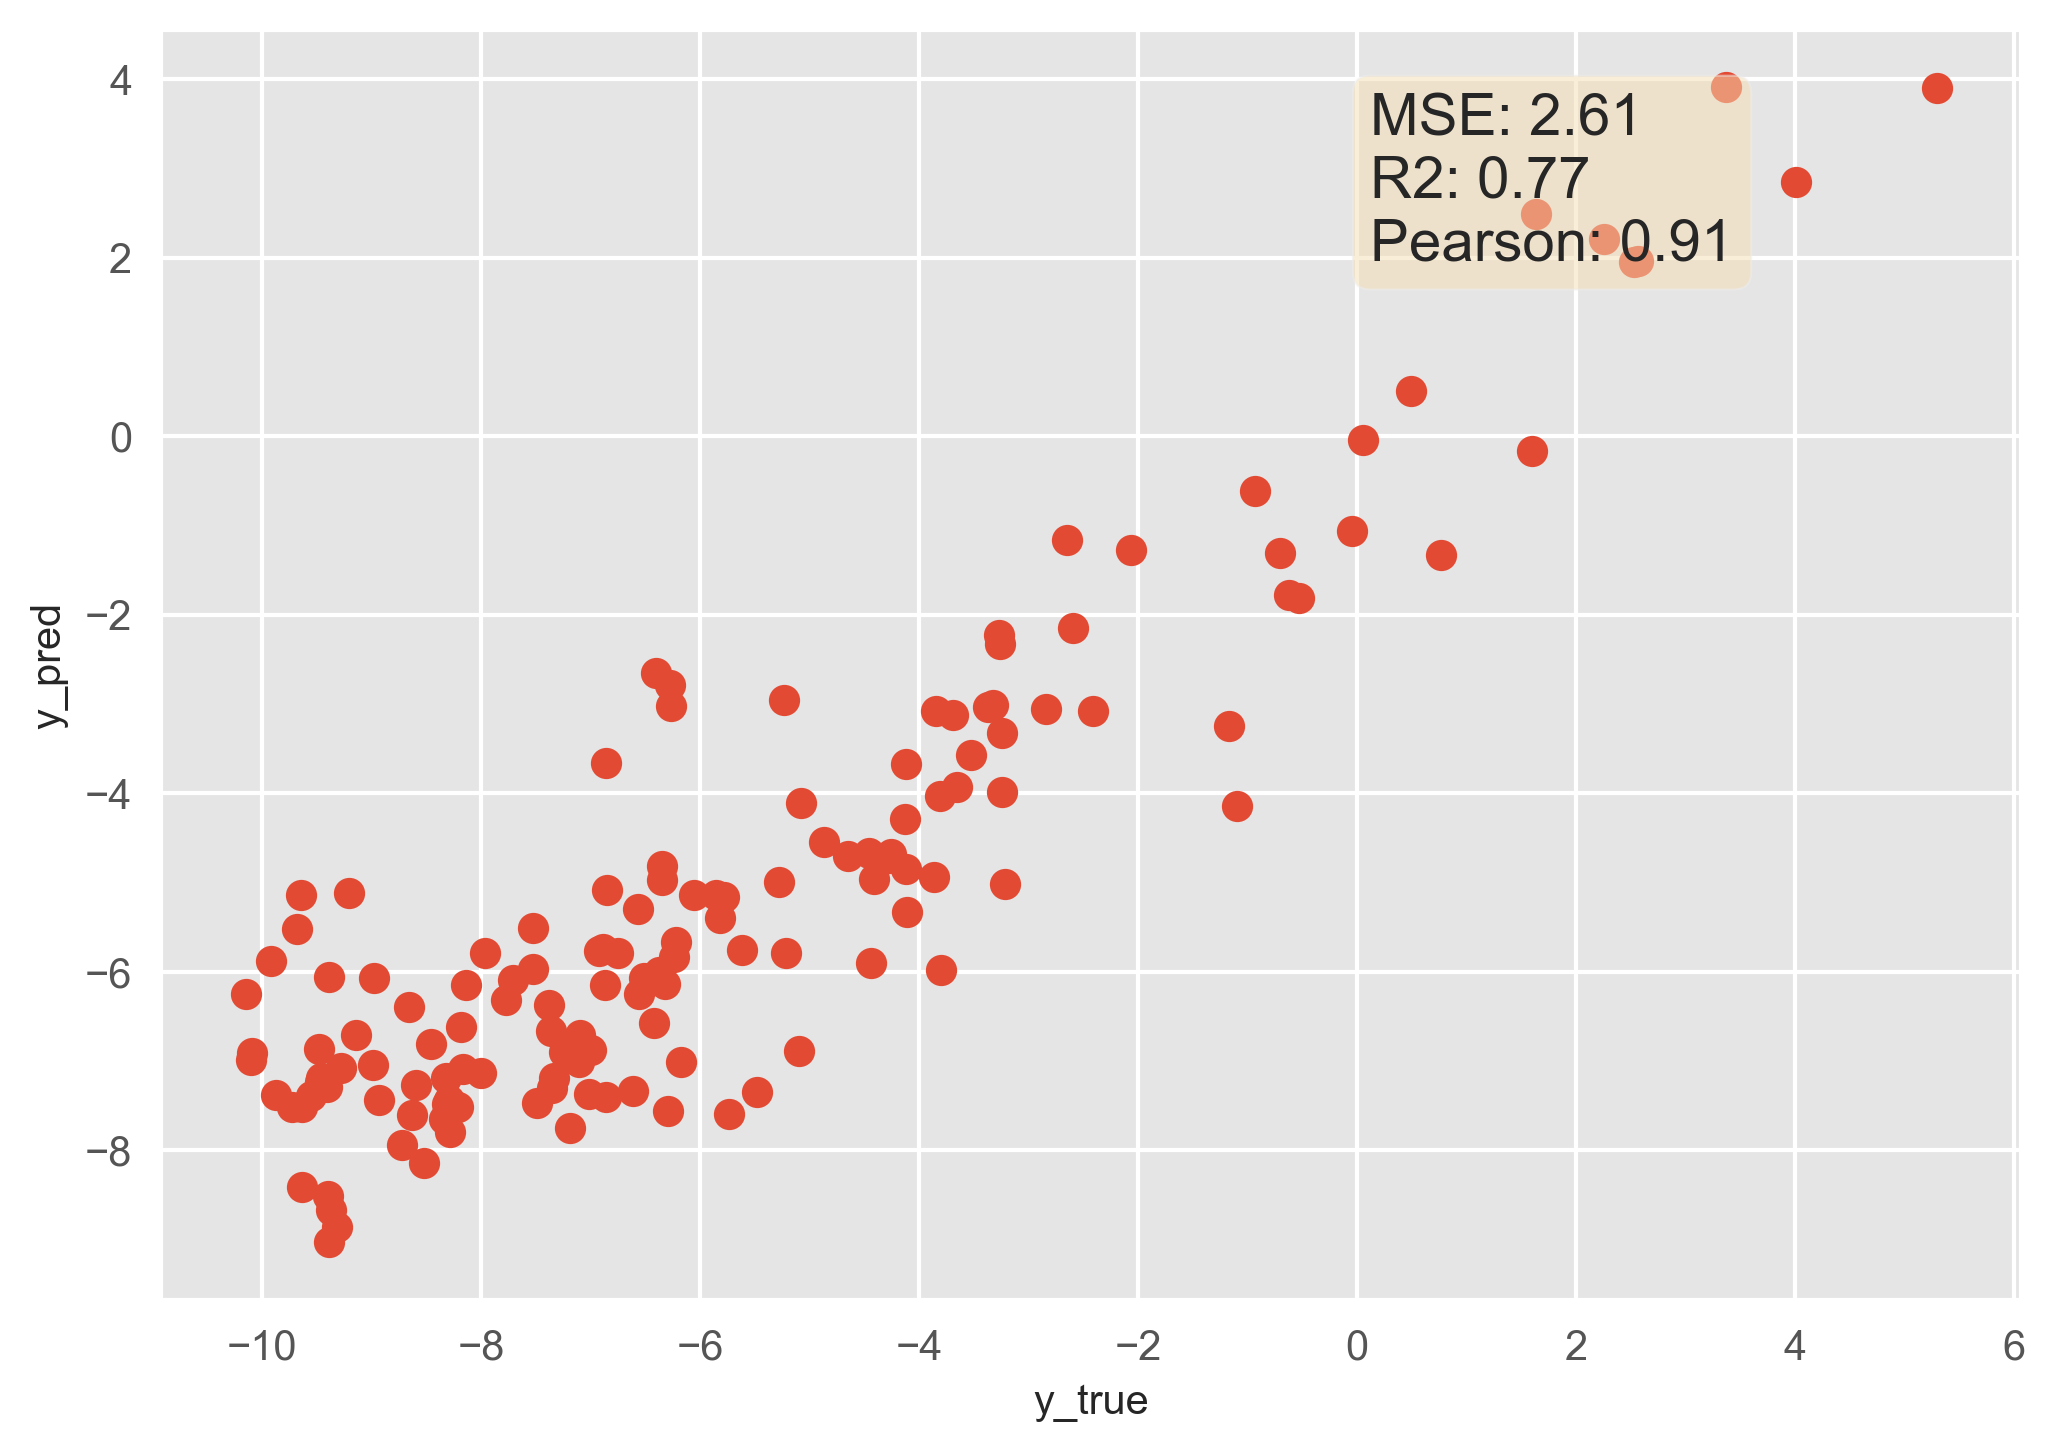

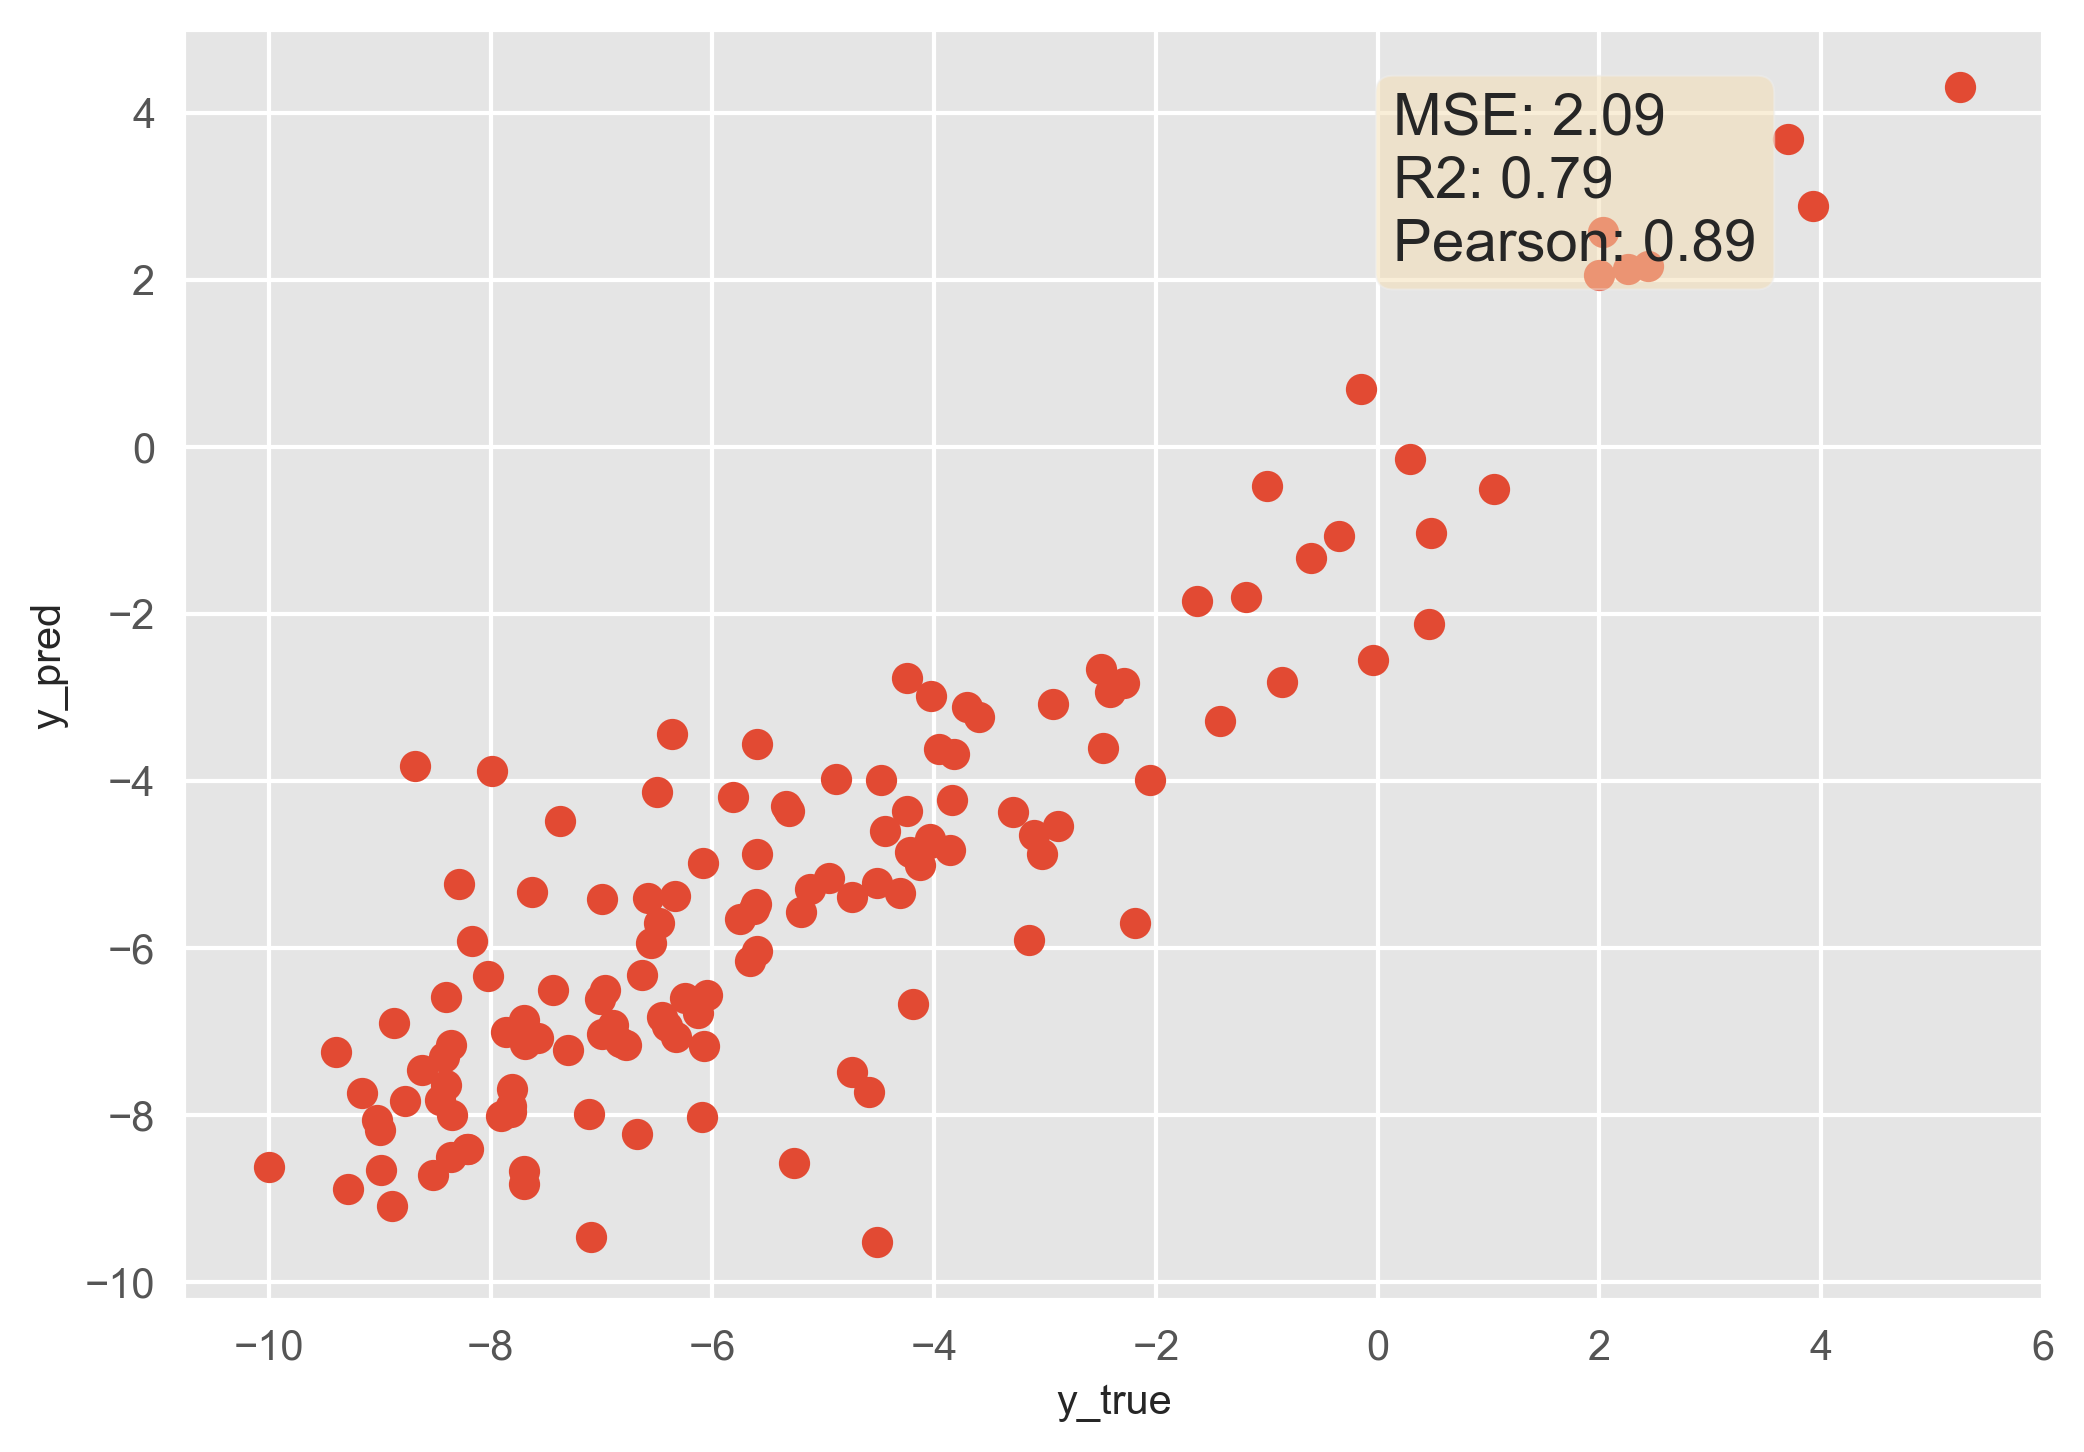

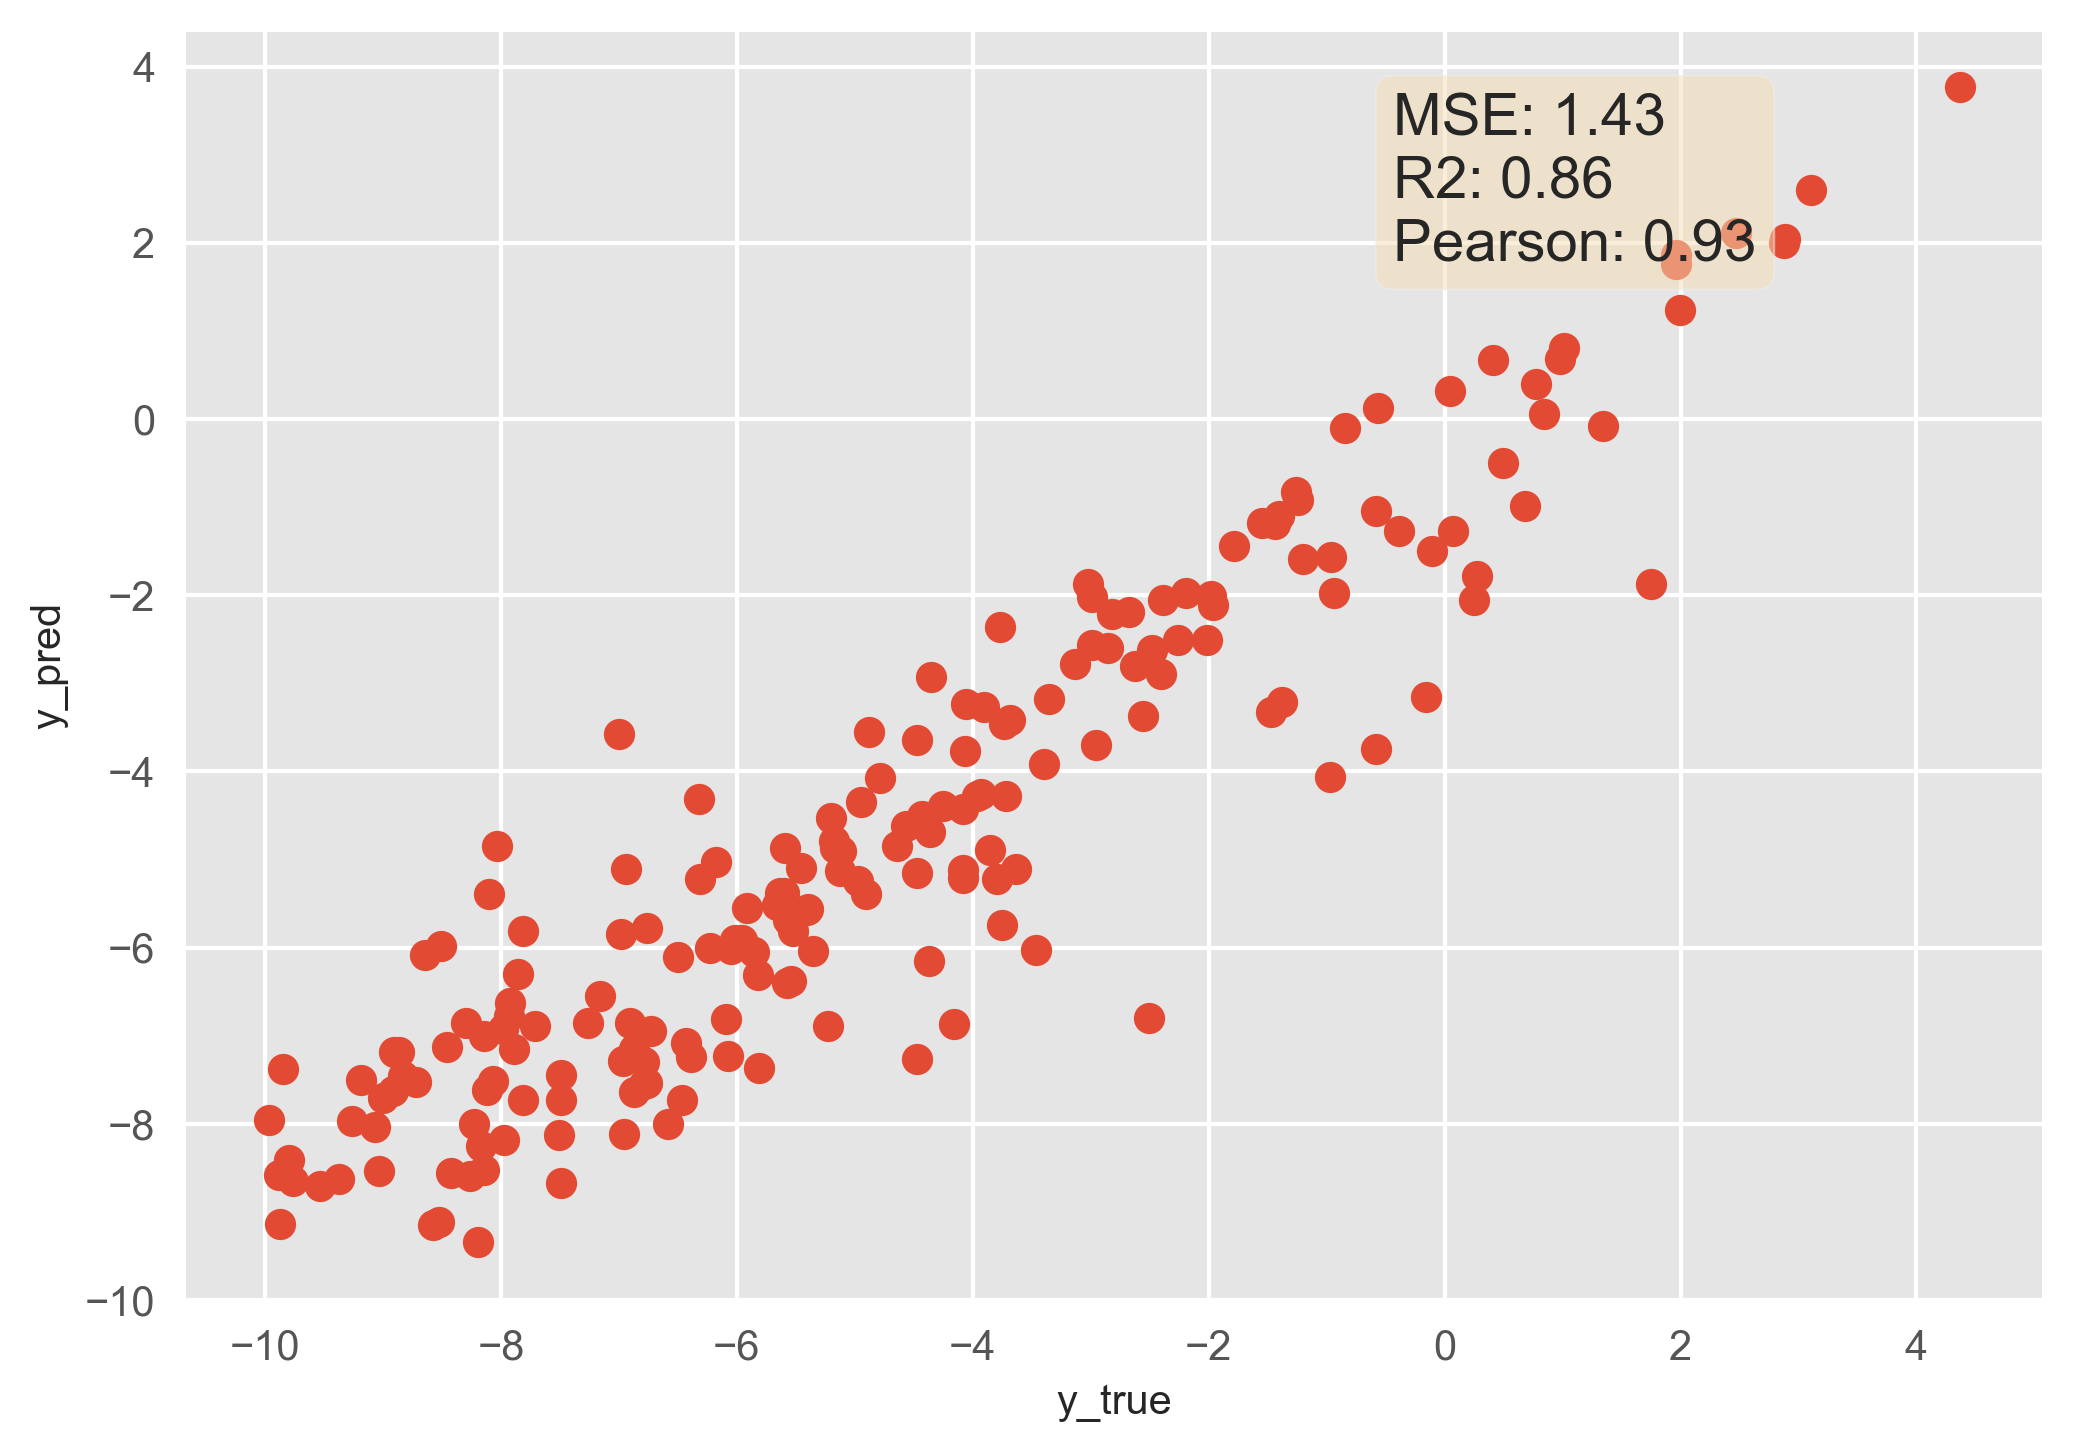

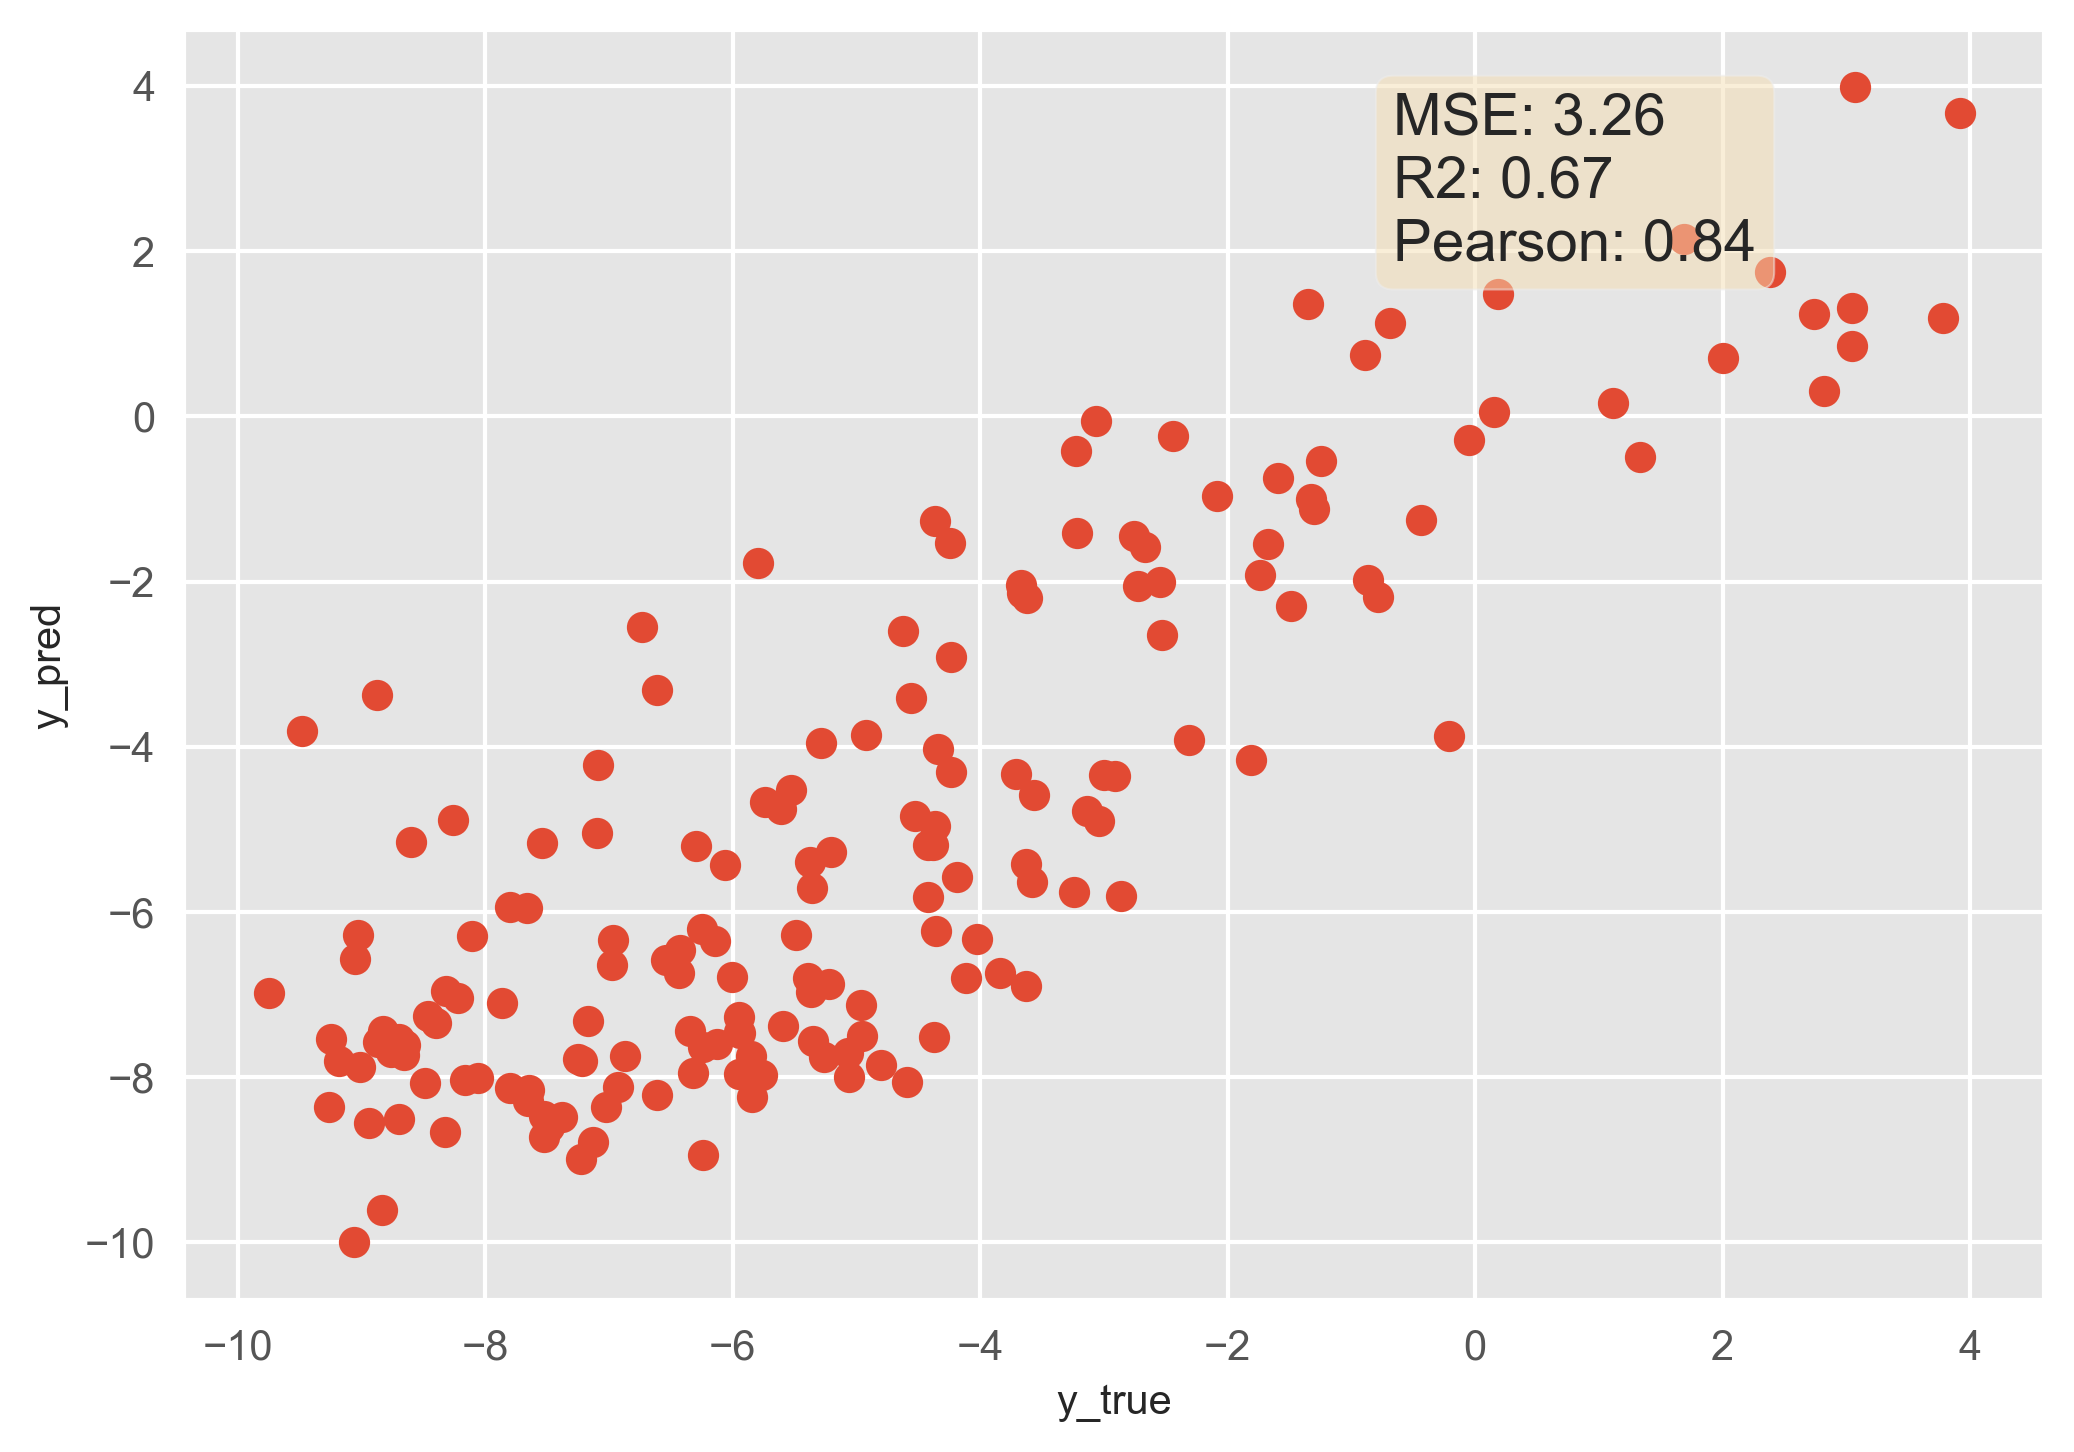

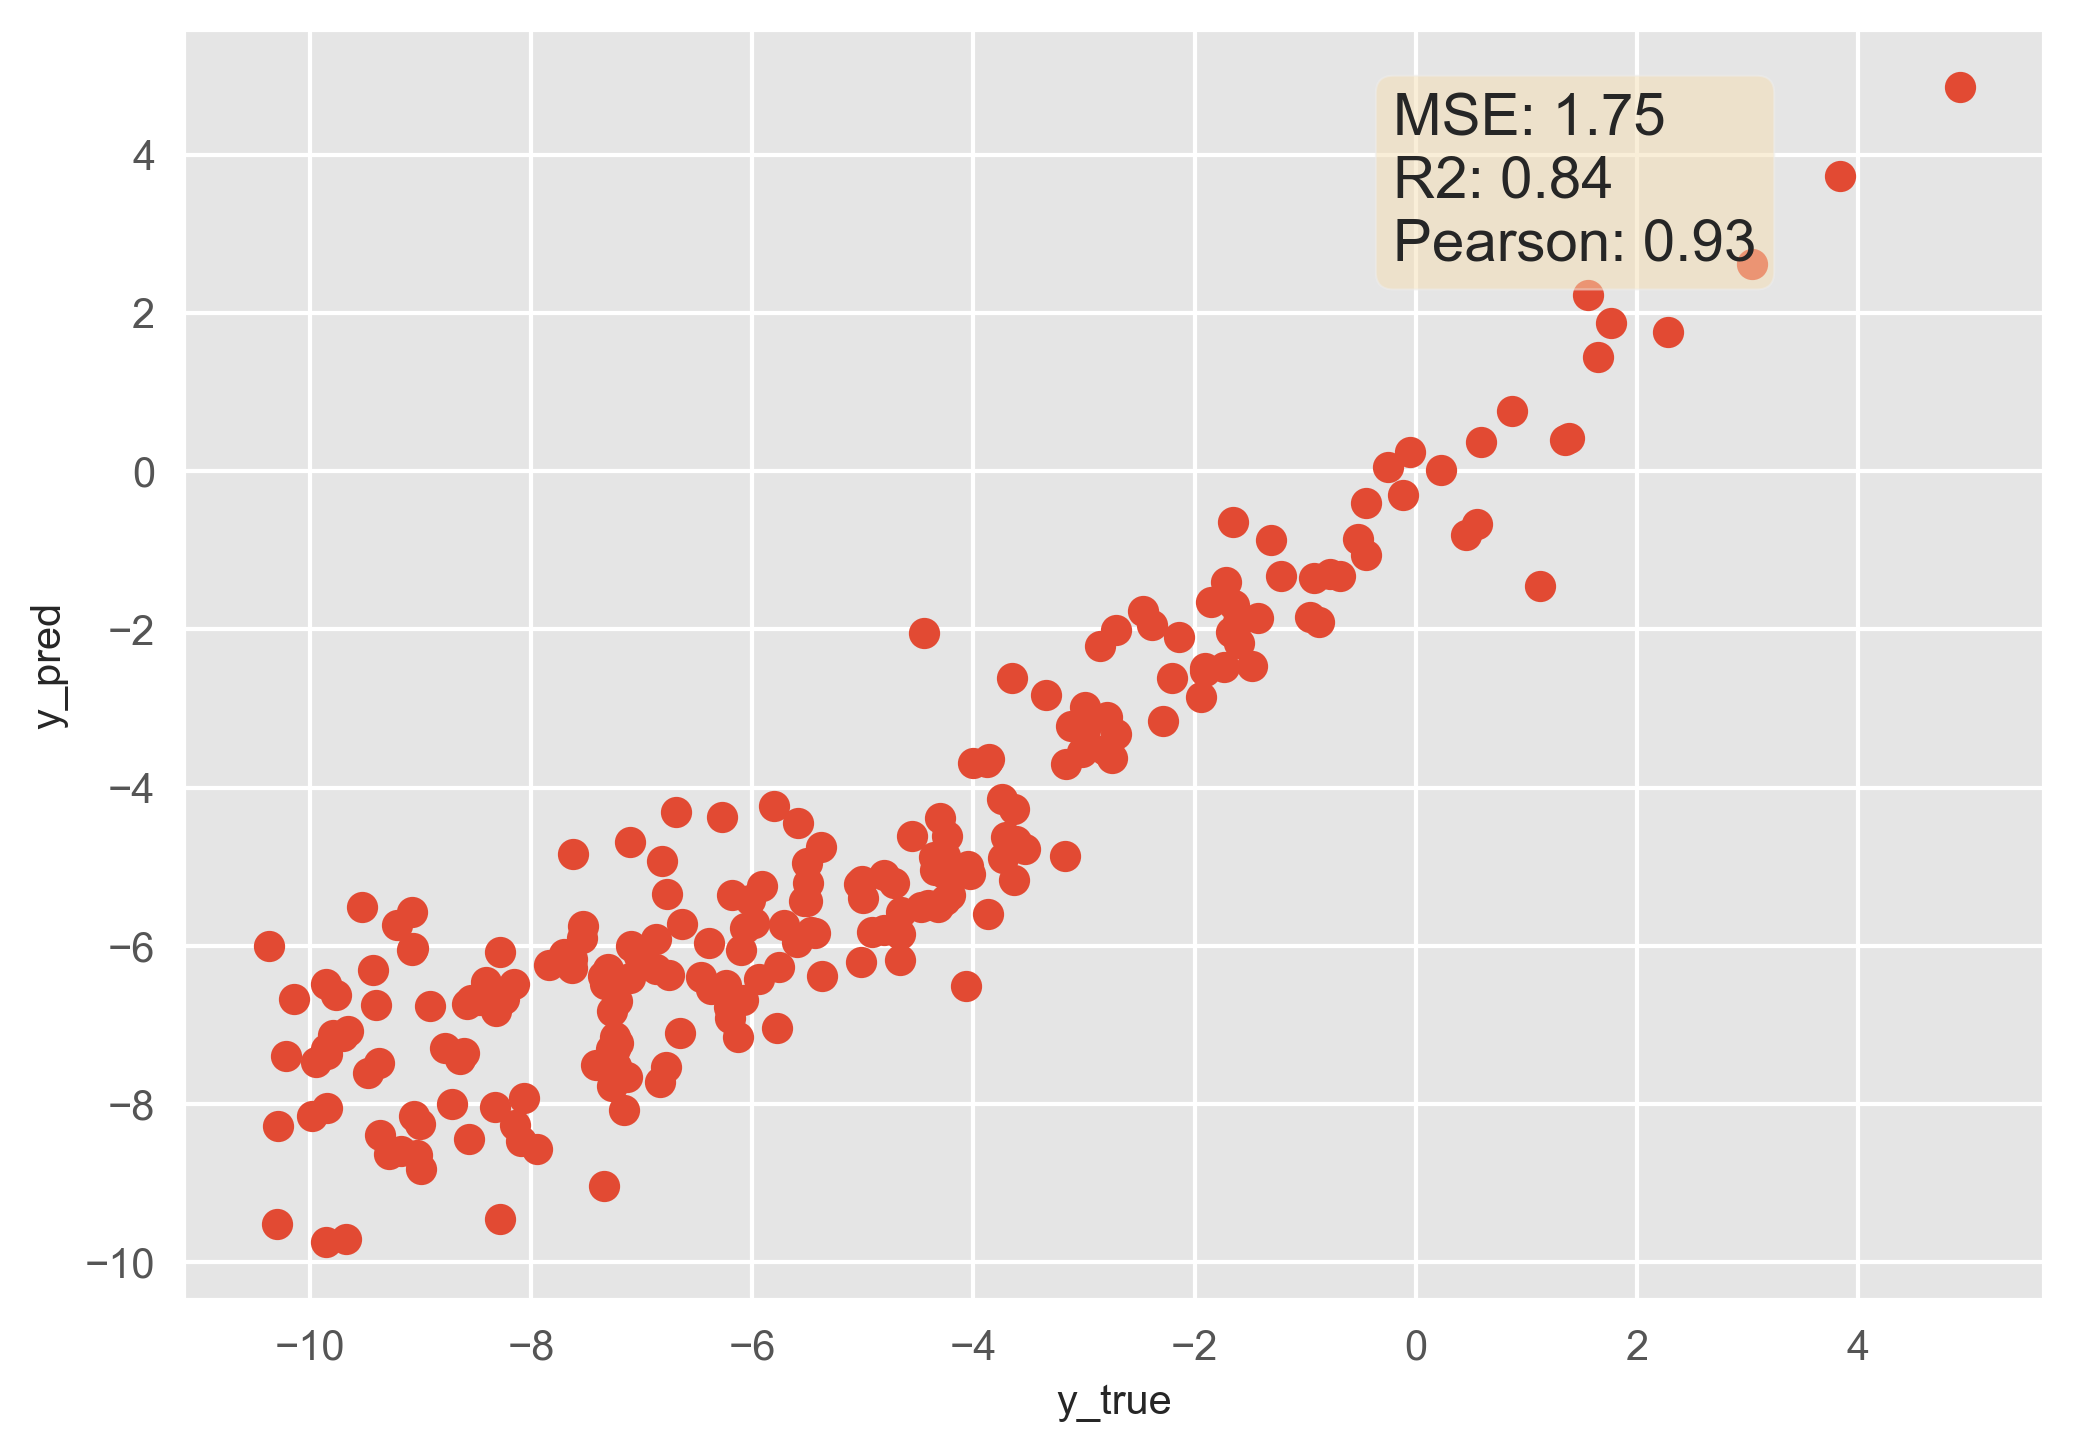

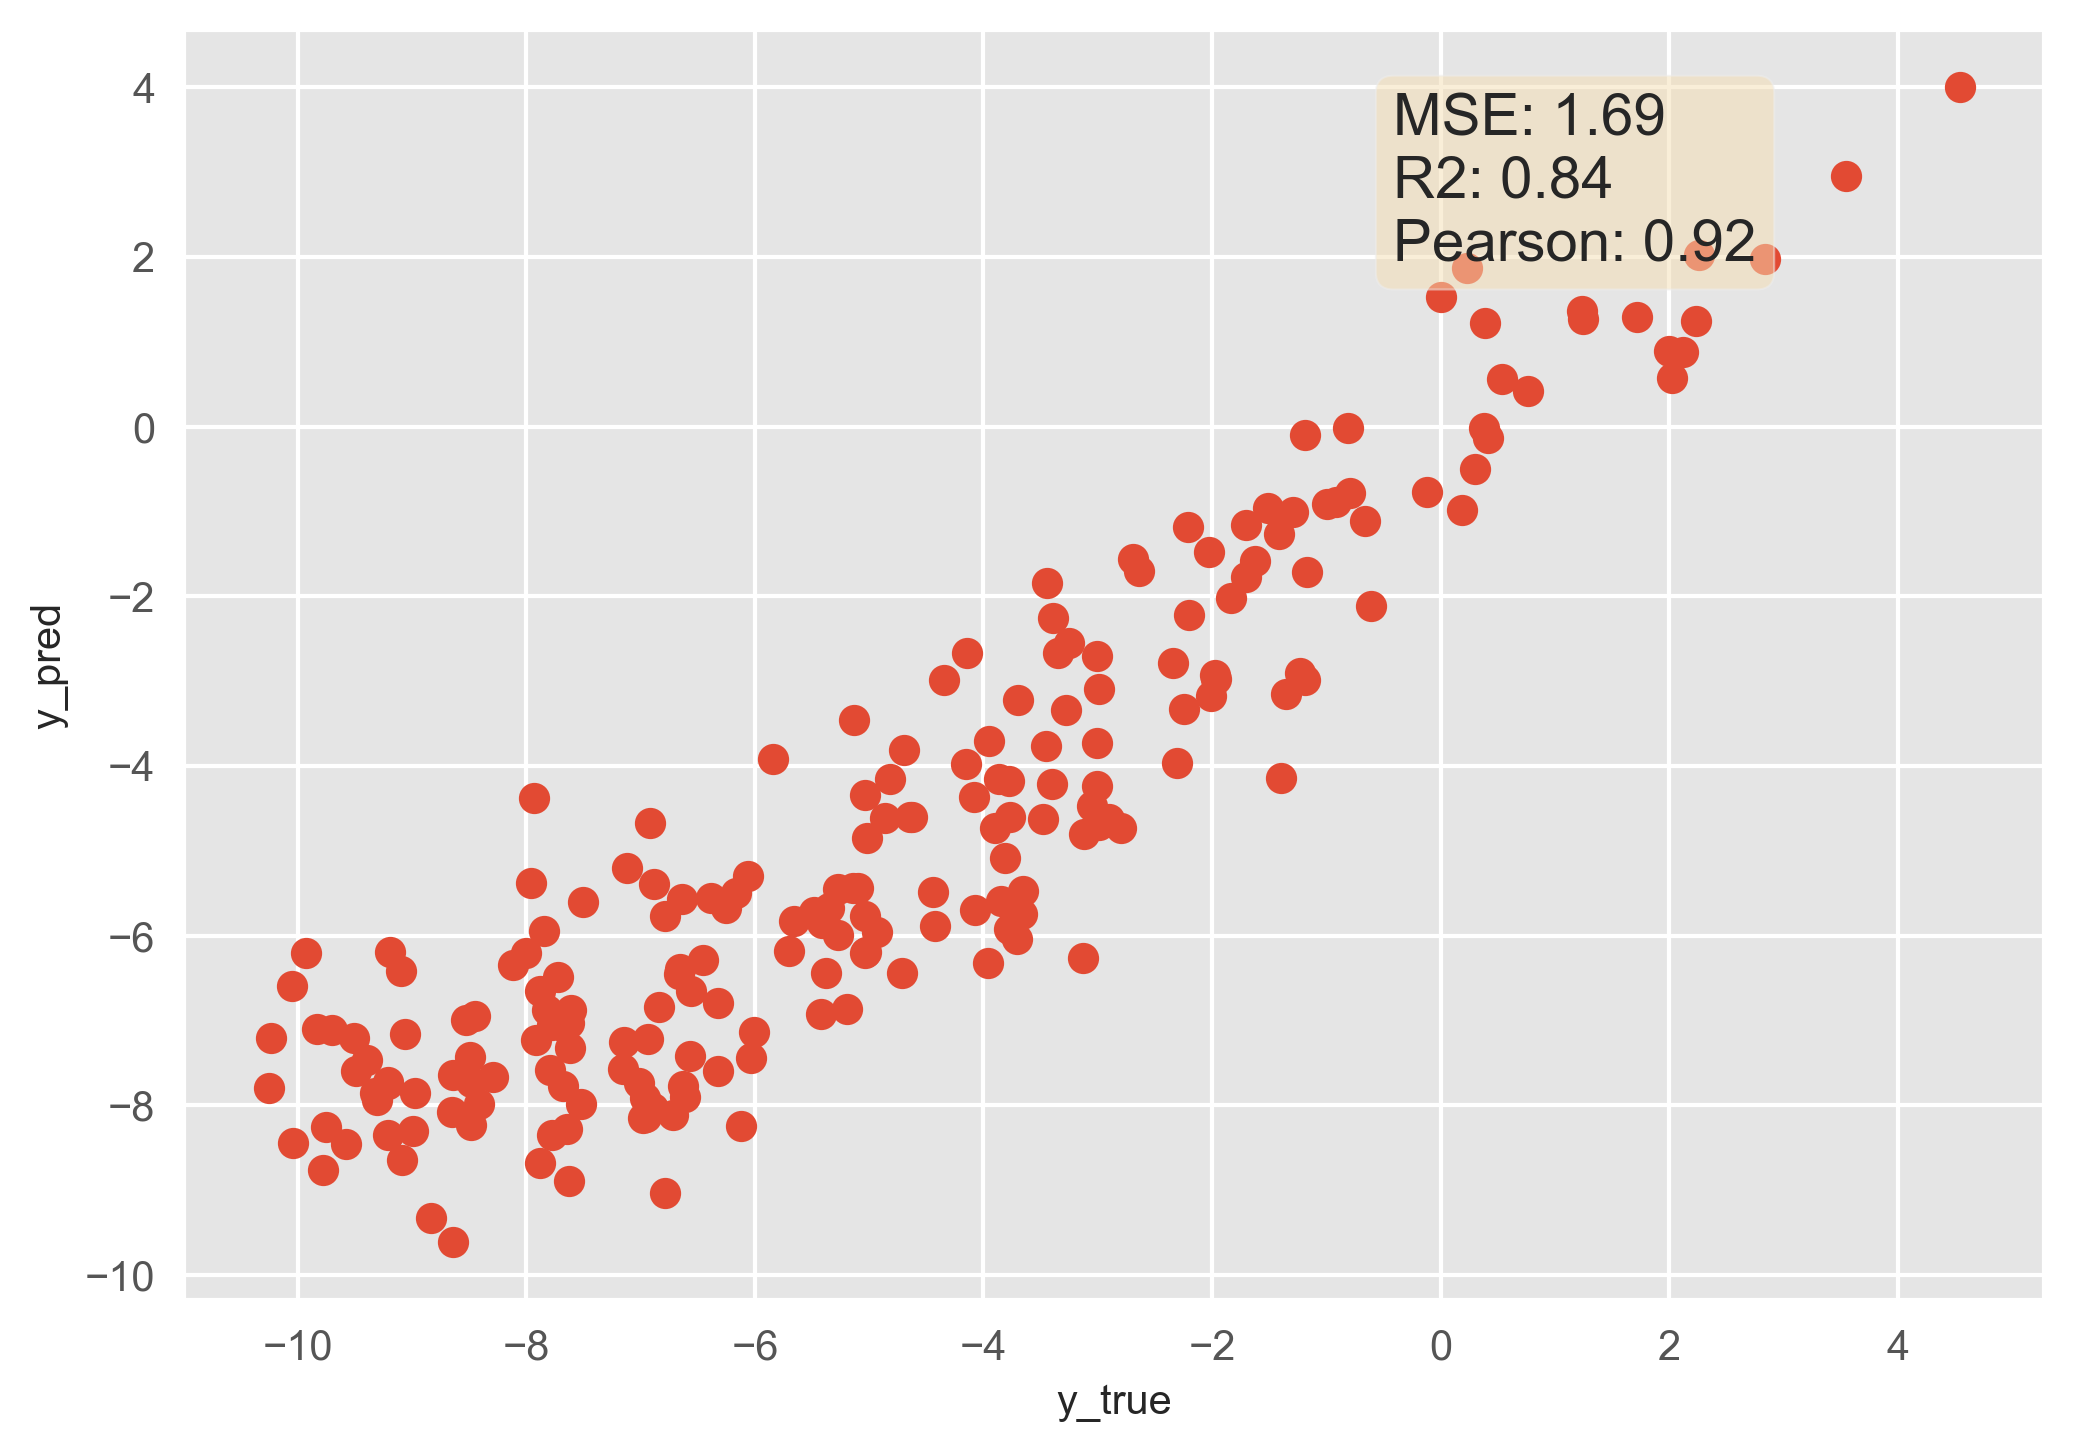

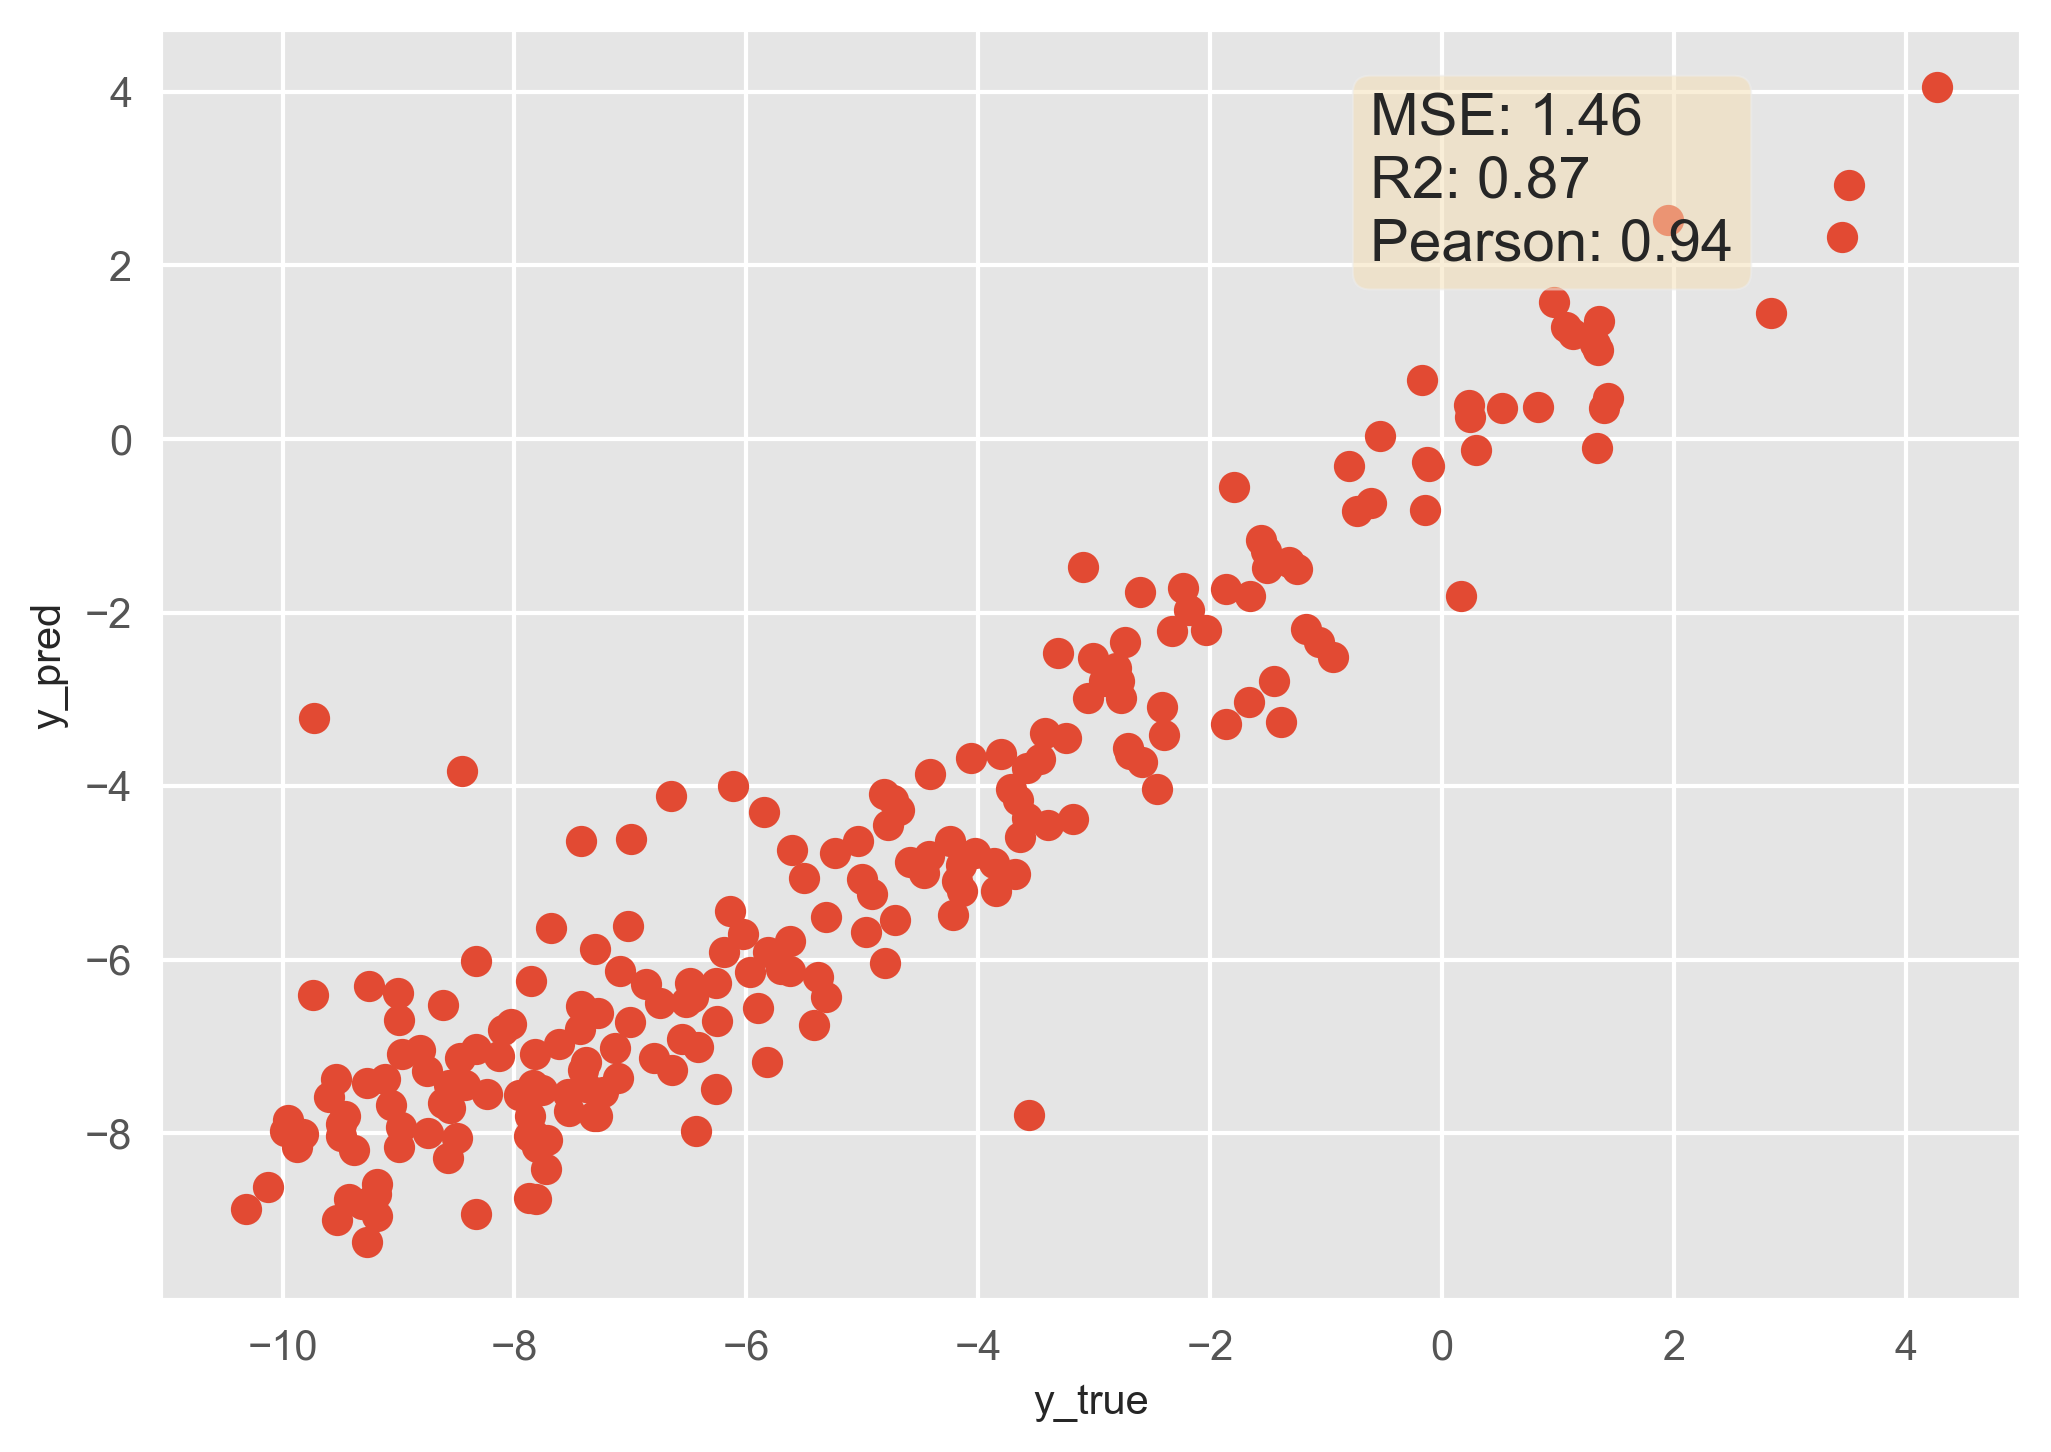

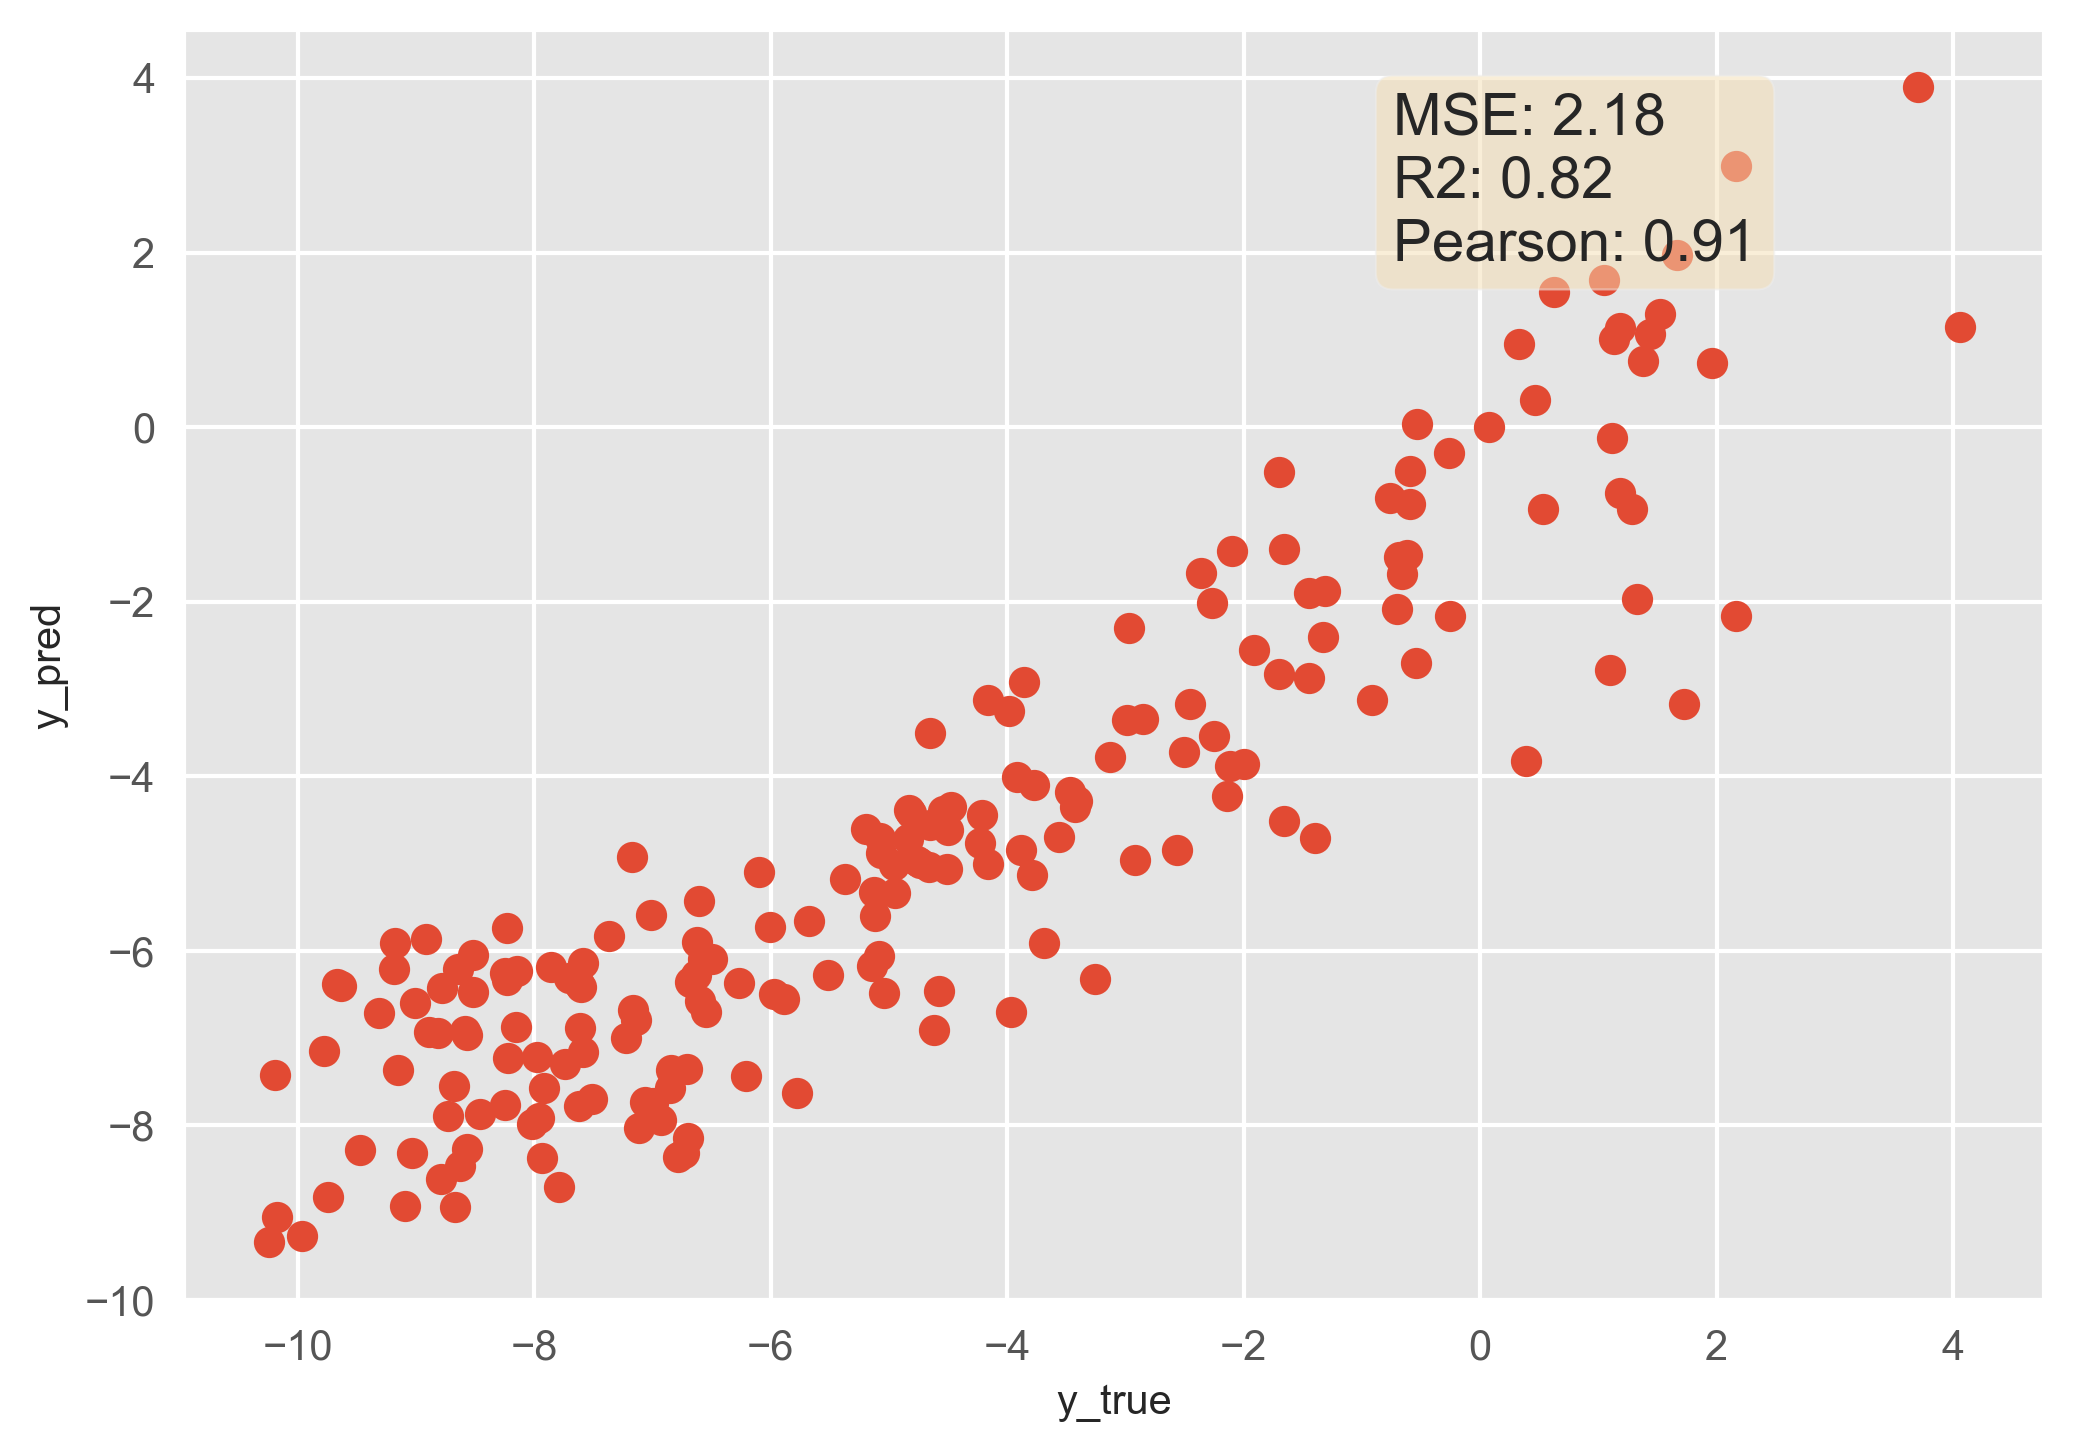

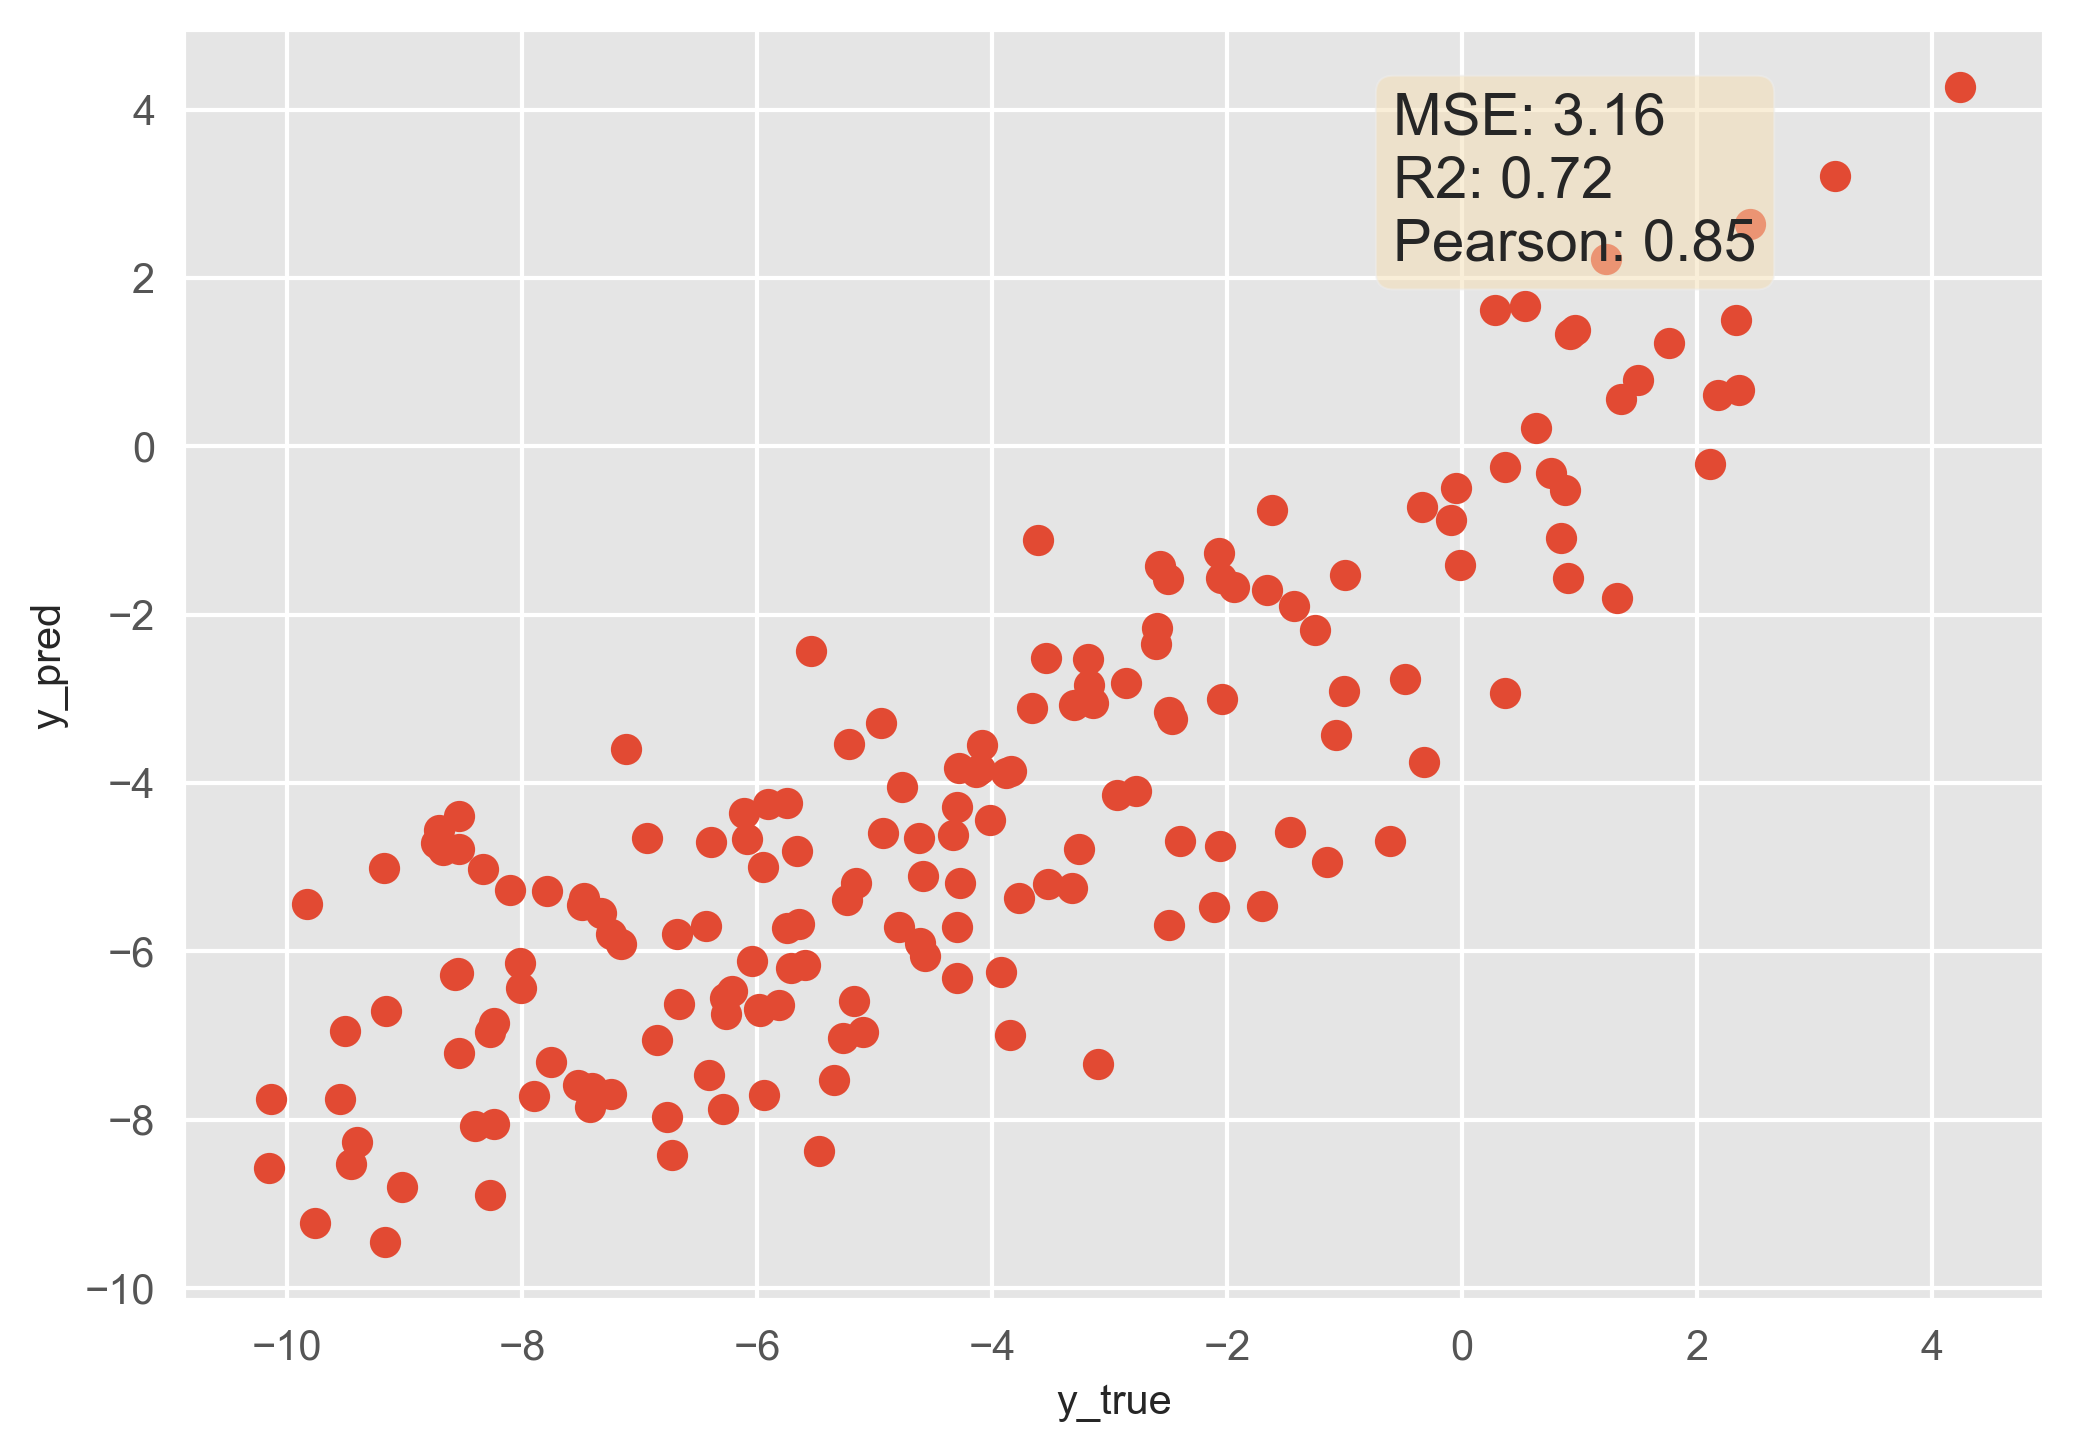

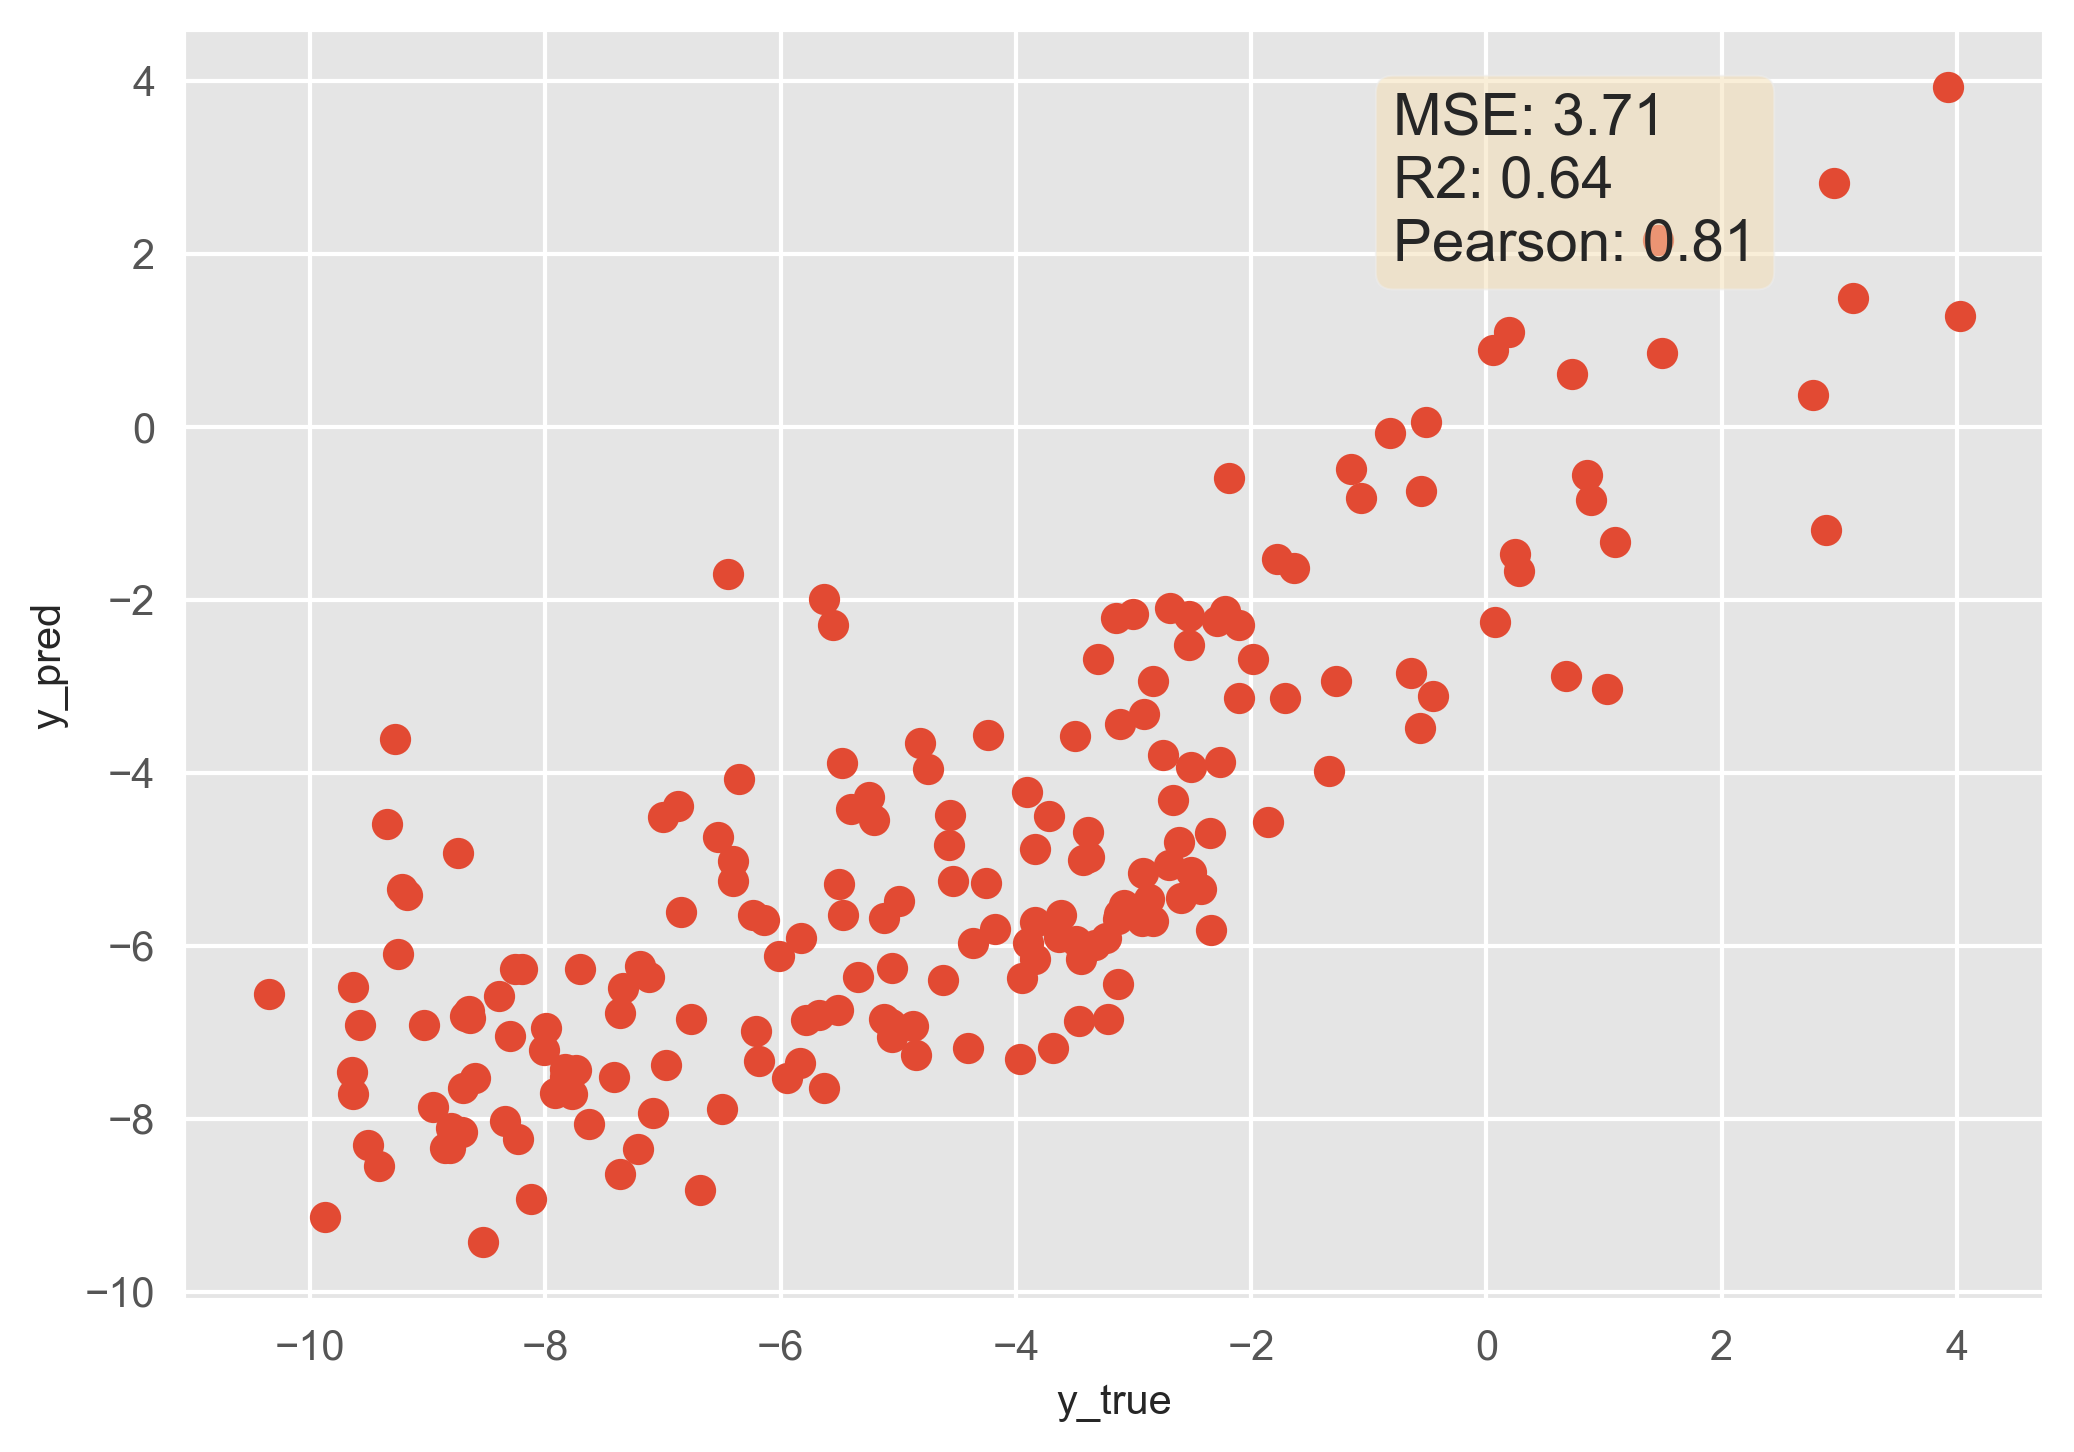

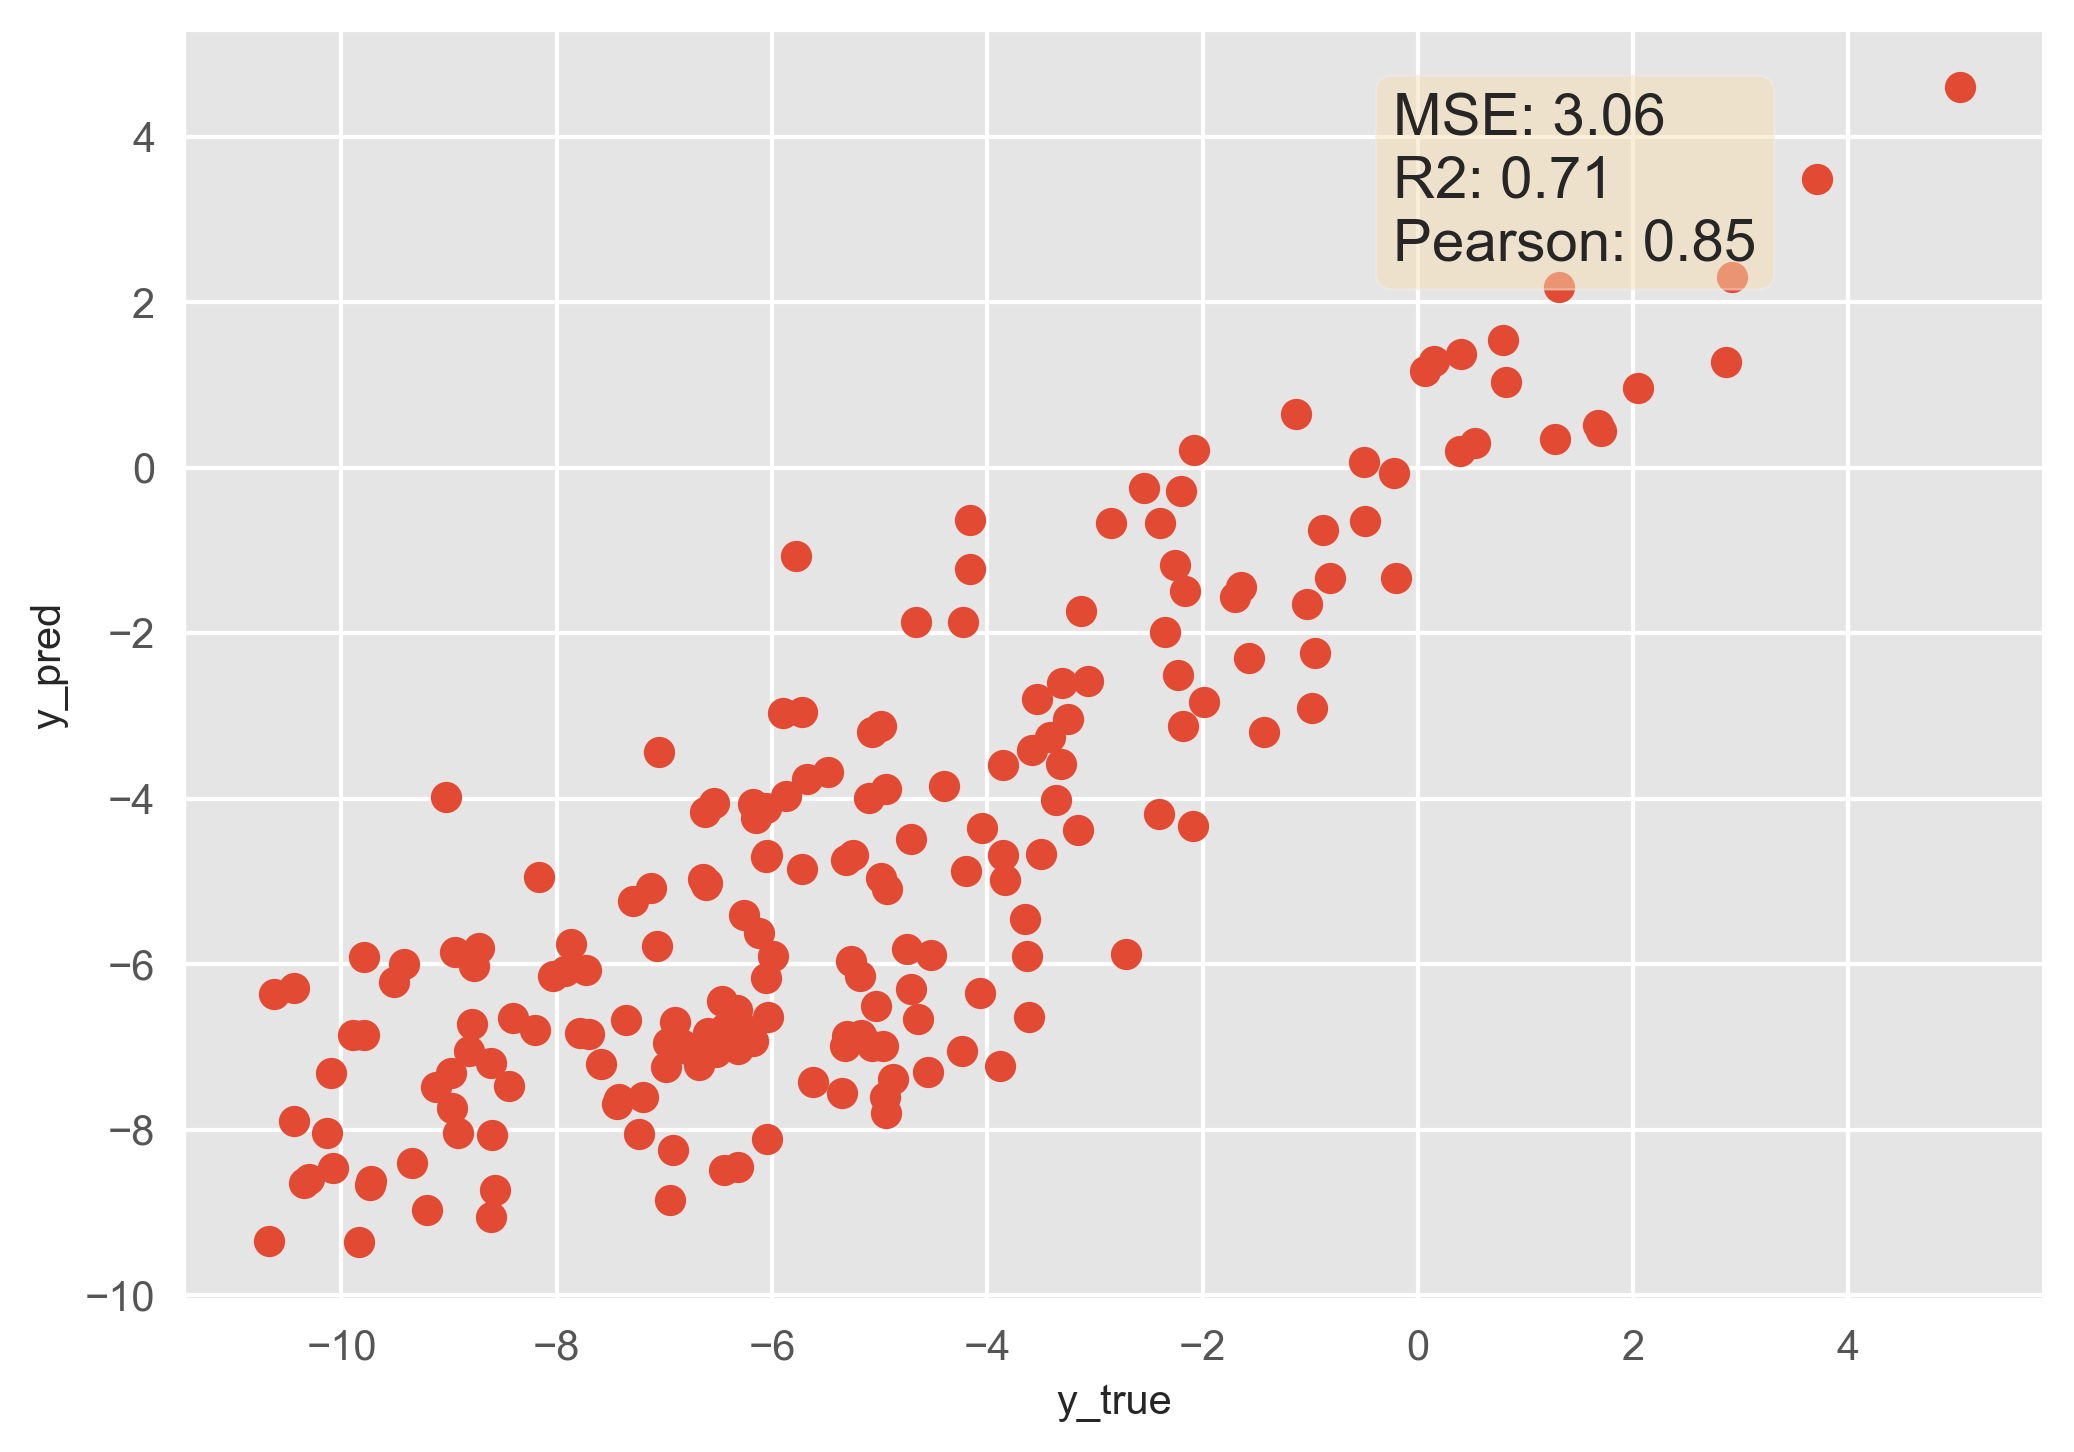

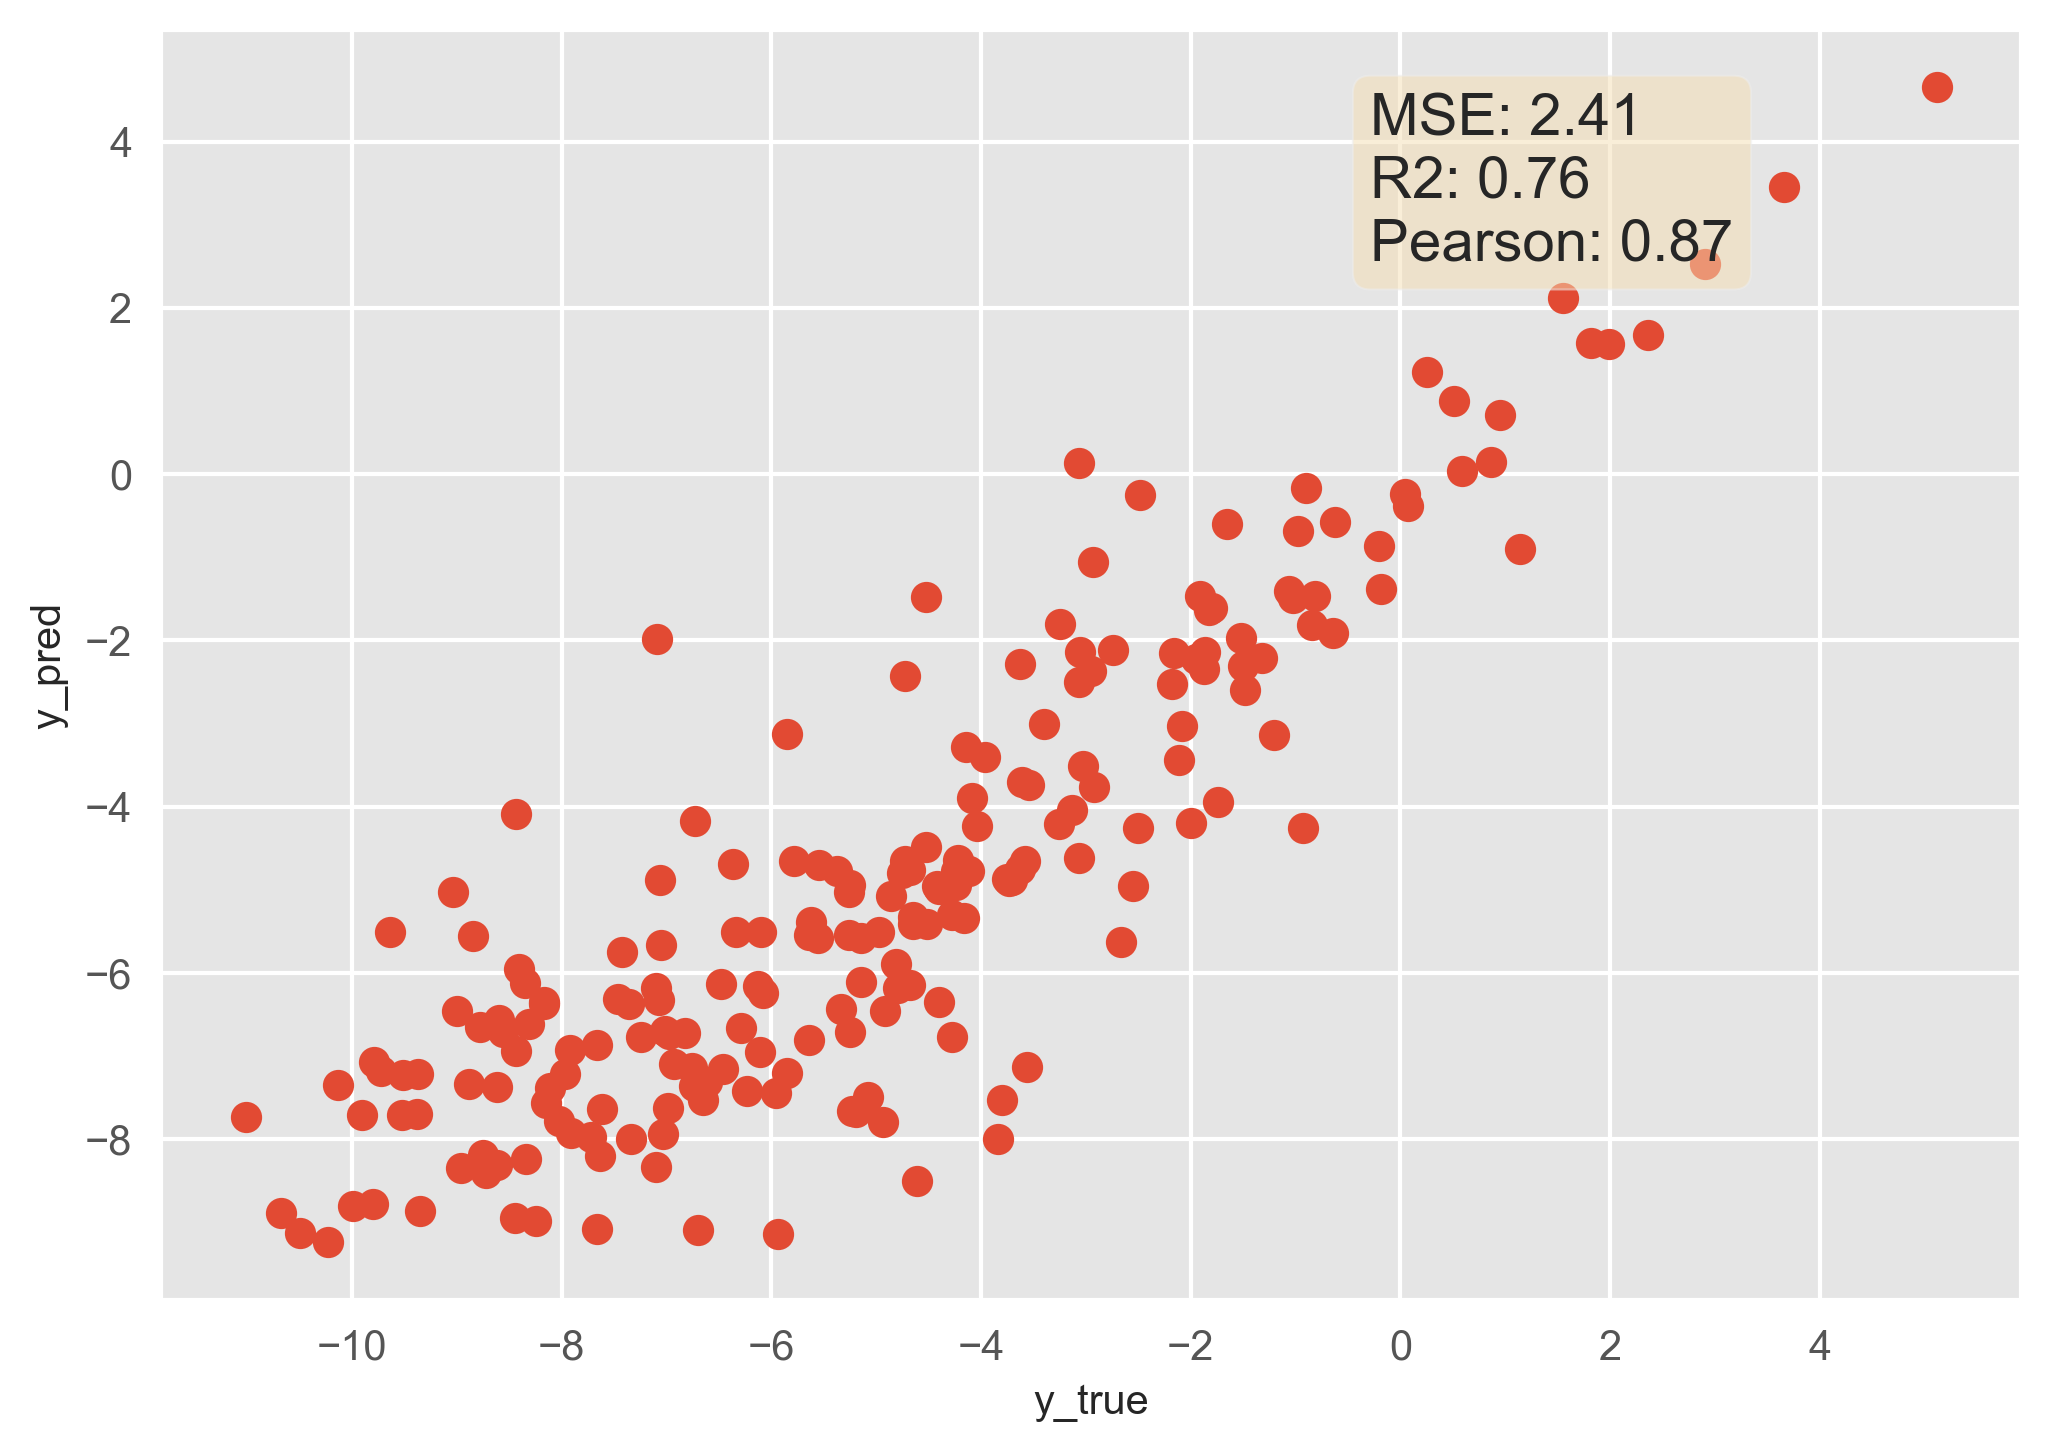

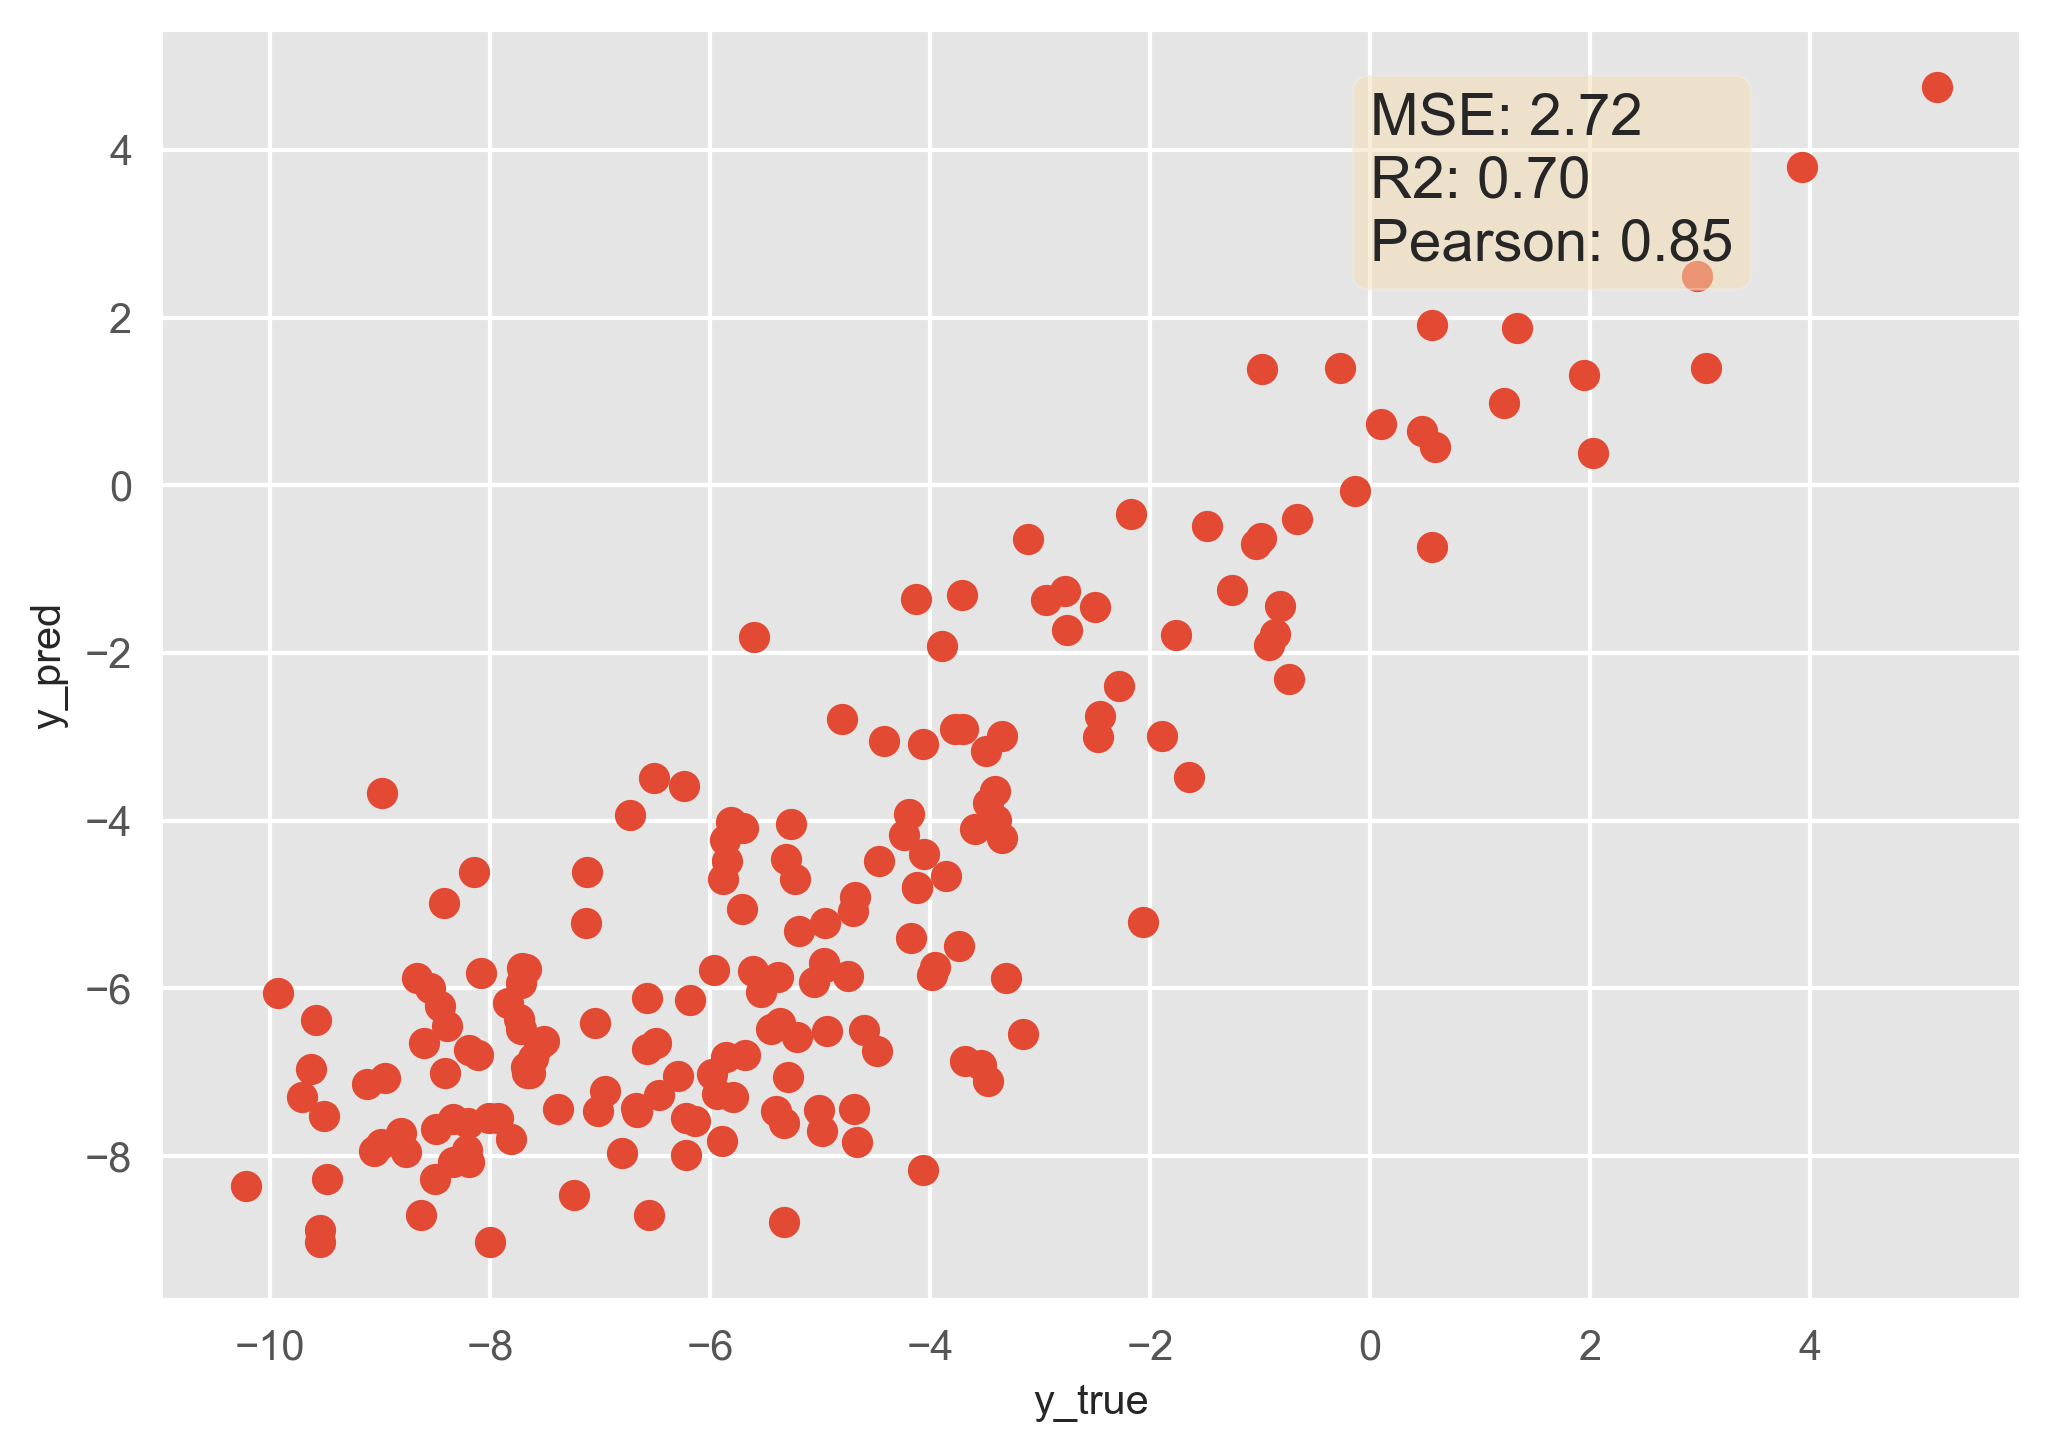

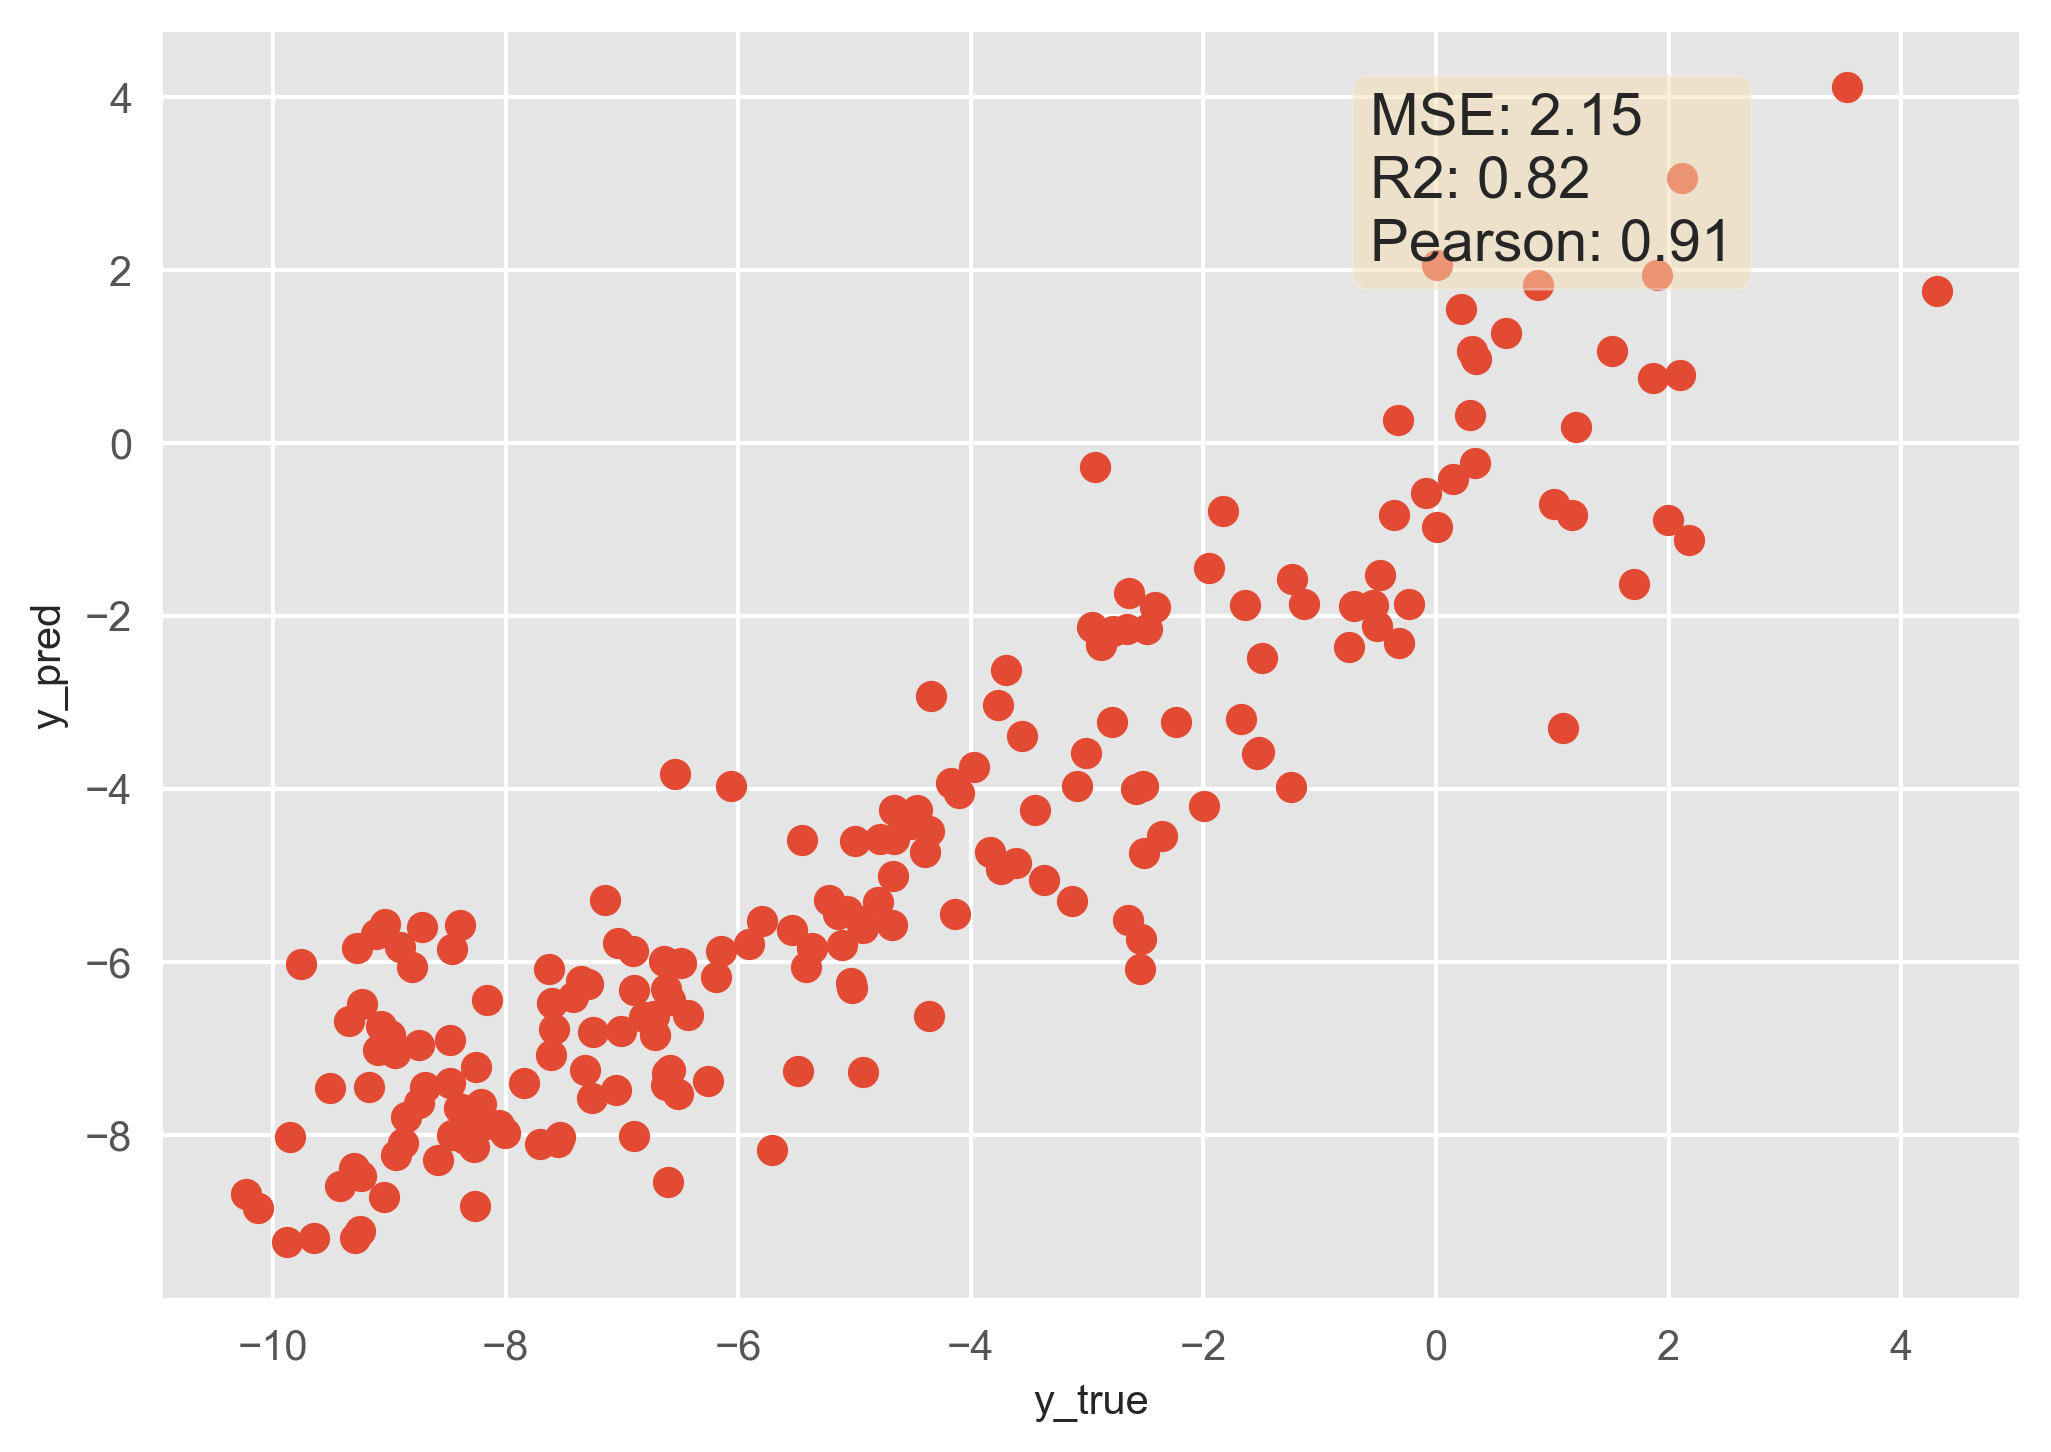

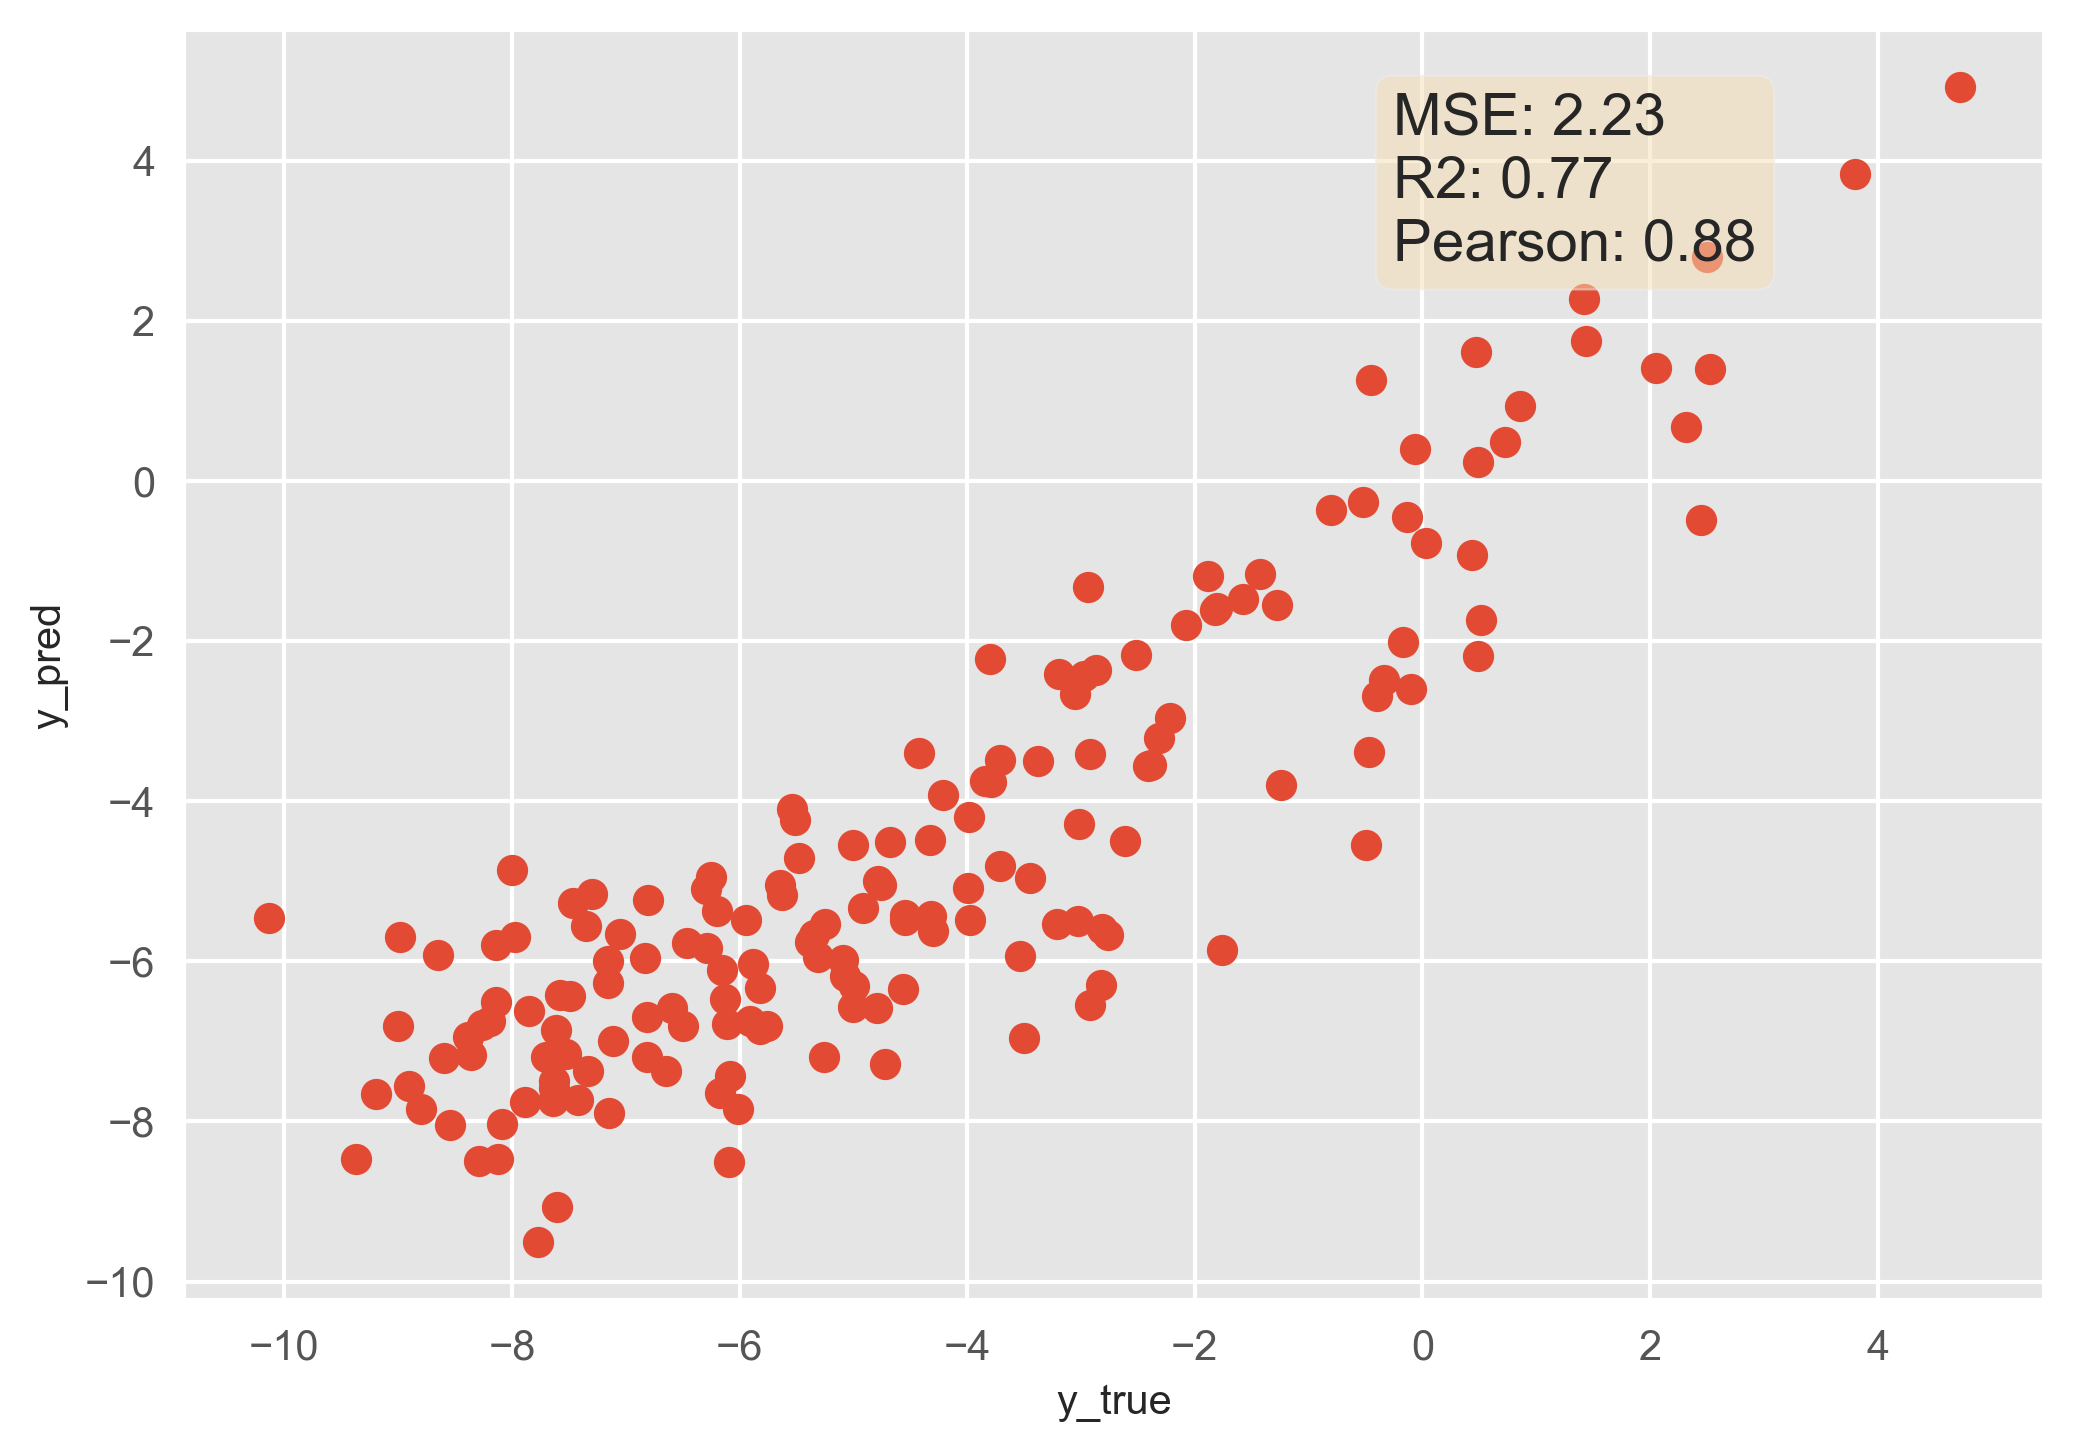

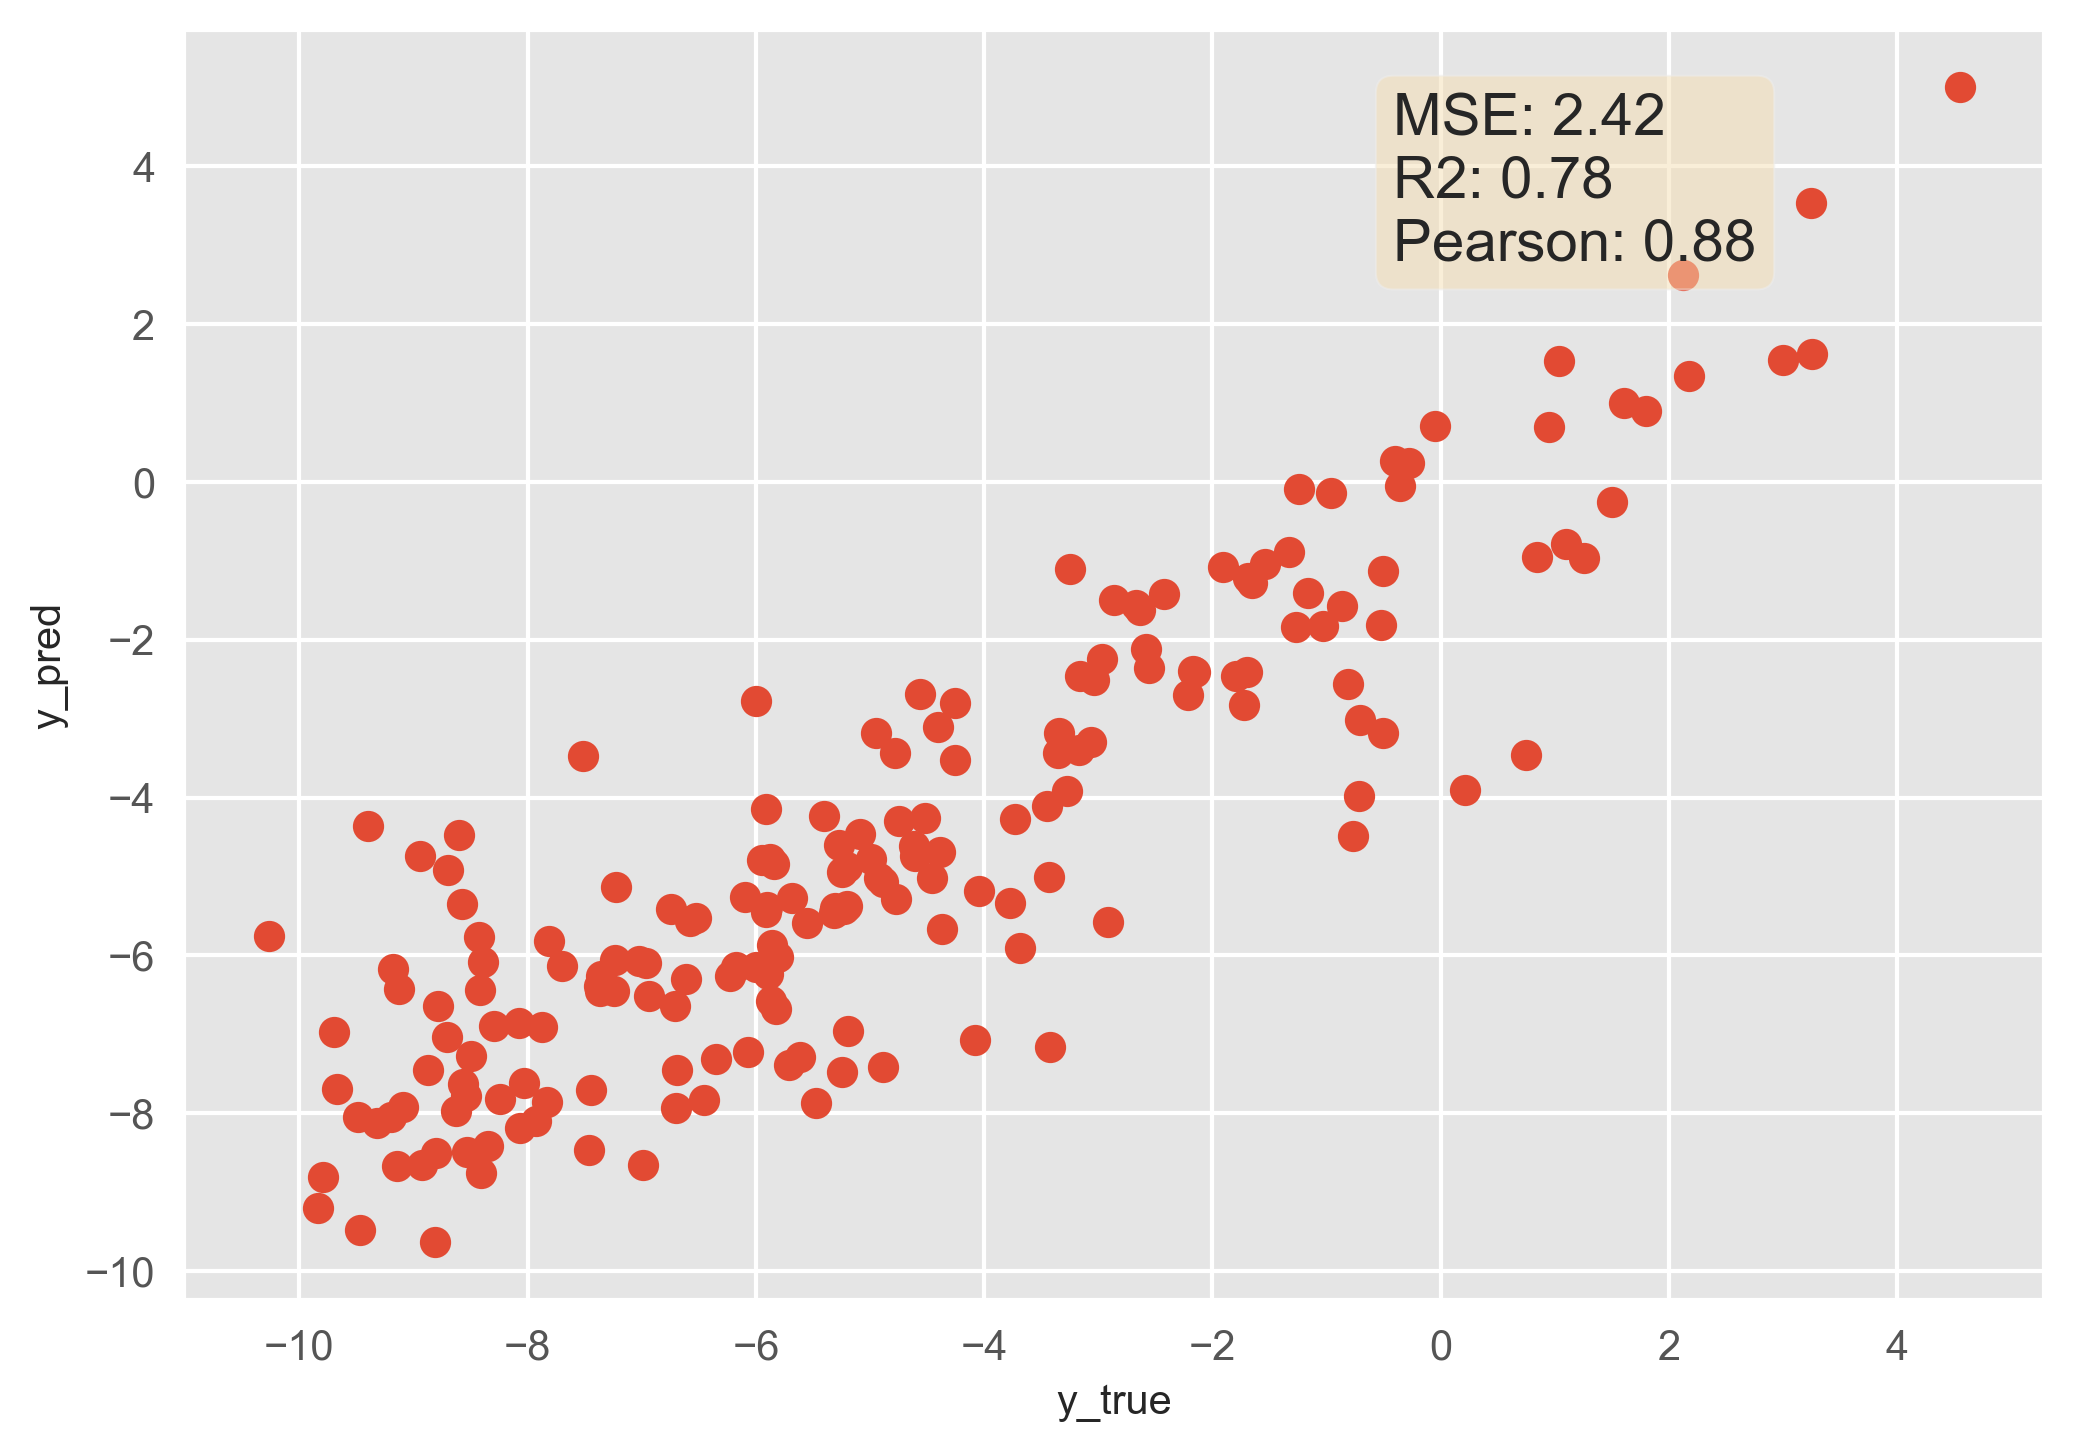

In [4]:
##Testing Each NP independently## Which ones are hard to predict and which ones are easy?
#easy to hard NPUNID 1,20,19,16,7,31,34,34
df_filepath = 'Input_data/Save_files/df_2_Synth.xlsx'
df_a = pd.read_excel(df_filepath, header=0)
# labels= df_a['Abundance'].copy()
# id_col= df_a['NPUNID'].copy()
# label_abund=np.ravel(labels)

# NPUNID_list=[1,20,19,16,7,31,34,43,44]
NPUNID_list=df_a['NPUNID'].unique().tolist()
id_list=NPUNID_list
# Initialize a list to hold MSE scores for each removed ID
pearson_scores = []
r2_scores = []
mse = []

i=0.0001

model=RandomForestRegressor(n_estimators=100)
print(df_a.shape)
# Loop through each ID in the list
eval_df = pd.DataFrame(columns=['Abundandce Filter', 'NPUNID', 'MSE', 'R2', 'Pearson'])
# for i in Abund_filter:
df_a=df_a.drop(columns=['Entry','Unnamed: 0','Unnamed: 5','BatchID','Sequence','Sample_num','Protein Source','Abundance_Controls','Ligands','Raw_FileID'])
df_a= df_a[df_a['Abundance']>=i].copy()

for NPID in id_list:
    print(NPID)
    df=df_a.copy()
    # Remove the row with the current ID from the dataframe
    removed_row = df.loc[df['NPUNID'] == NPID].copy()
    df = df.loc[df['NPUNID'] != NPID].copy()

    # Split the remaining data into features and target
    X_train = df.drop(['Abundance', 'NPUNID'], axis=1)
    X_test = removed_row.drop(['Abundance', 'NPUNID'], axis=1)
    y_train = np.ravel(df['Abundance'])
    y_train = np.log2(y_train)
    # print('y_train ', y_train.shape)
    # print('X_test ',X_test.shape)
    # print('X_train ',X_train.shape)


    step = 2
    RFE_Feats=20
    selector = RFE(model, n_features_to_select=RFE_Feats, step=step)
    selector = selector.fit(X_train, y_train)
    selector.support_
    ranking = selector.ranking_
    feat_list = selector.get_feature_names_out()
    X_train = X_train[feat_list].copy()

    # Fit a random forest regression model to the training data
    model.fit(X_train, y_train)

    # Use the trained model to predict on the removed ID
    X_test = removed_row[X_train.columns]
    y_true = removed_row['Abundance']
    y_true= np.ravel(y_true)
    y_true= np.log2(y_true)
    y_pred = model.predict(X_test)
    # Calculate the Accuracy scores and add it to the list
    pearson, _ = pearsonr(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mse_score = mean_squared_error(y_true, y_pred)

    pearson_scores.append(pearson)
    r2_scores.append(r2)
    mse.append(mse_score)
    # plot the scatter plot
    fig, ax = plt.subplots()
    plt.style.use('ggplot')
    plt.rcParams['figure.dpi'] = 300
    ax.scatter(y_true, y_pred)
    ax.set_xlabel('y_true')
    ax.set_ylabel('y_pred')


    # add the metrics box to the plot
    box_text = f"MSE: {mse_score:.2f}\nR2: {r2:.2f}\nPearson: {pearson:.2f}"
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax.text(0.65, 0.95, box_text, transform=ax.transAxes, fontsize=14,verticalalignment='top', bbox=props)
    plt.savefig('Output_data/NPtest_synth_' + str(NPID) + '.png', bbox_inches='tight')
    # print(id)
    tmp=pd.DataFrame({'Abundandce Filter': i,
                              'NPUNID':NPID,
                              'MSE':mse_score,
                              'R2':r2,
                              'Pearson':pearson},index=[0])
    eval_df = pd.concat([eval_df,tmp],ignore_index=True,axis=0)

eval_df.to_excel('Output_data/AbundThresholdingRFR_NP(2).xlsx', index=False)
# out=pd.DataFrame(list(zip(NPUNID_list,Abund_filter,pearson_scores,r2_scores,mse)), columns=['NPUNID','Abundance Filter','Pearson', 'R2', 'MSE'])
# out.to_excel('Output_data/PredictingEachNP_RFECV.xlsx',index=False)


In [14]:
model.fit(X_train,y_train)
y_true = removed_row['Abundance']
y_pred = model.predict(X_test)
# Calculate the Accuracy scores and add it to the list
pearson, _ = pearsonr(y_true, y_pred)
r2 = r2_score(y_true, y_pred)
mse_score = mean_squared_error(y_true, y_pred)

pearson_scores.append(pearson)
r2_scores.append(r2)
mse.append(mse_score)
print(id)
tmp=pd.DataFrame({'Abundandce Filter': i,
                          'NPUNID':id,
                          'MSE':mse_score,
                          'R2':r2,
                          'Pearson':pearson},index=[0])
eval_df = pd.concat([eval_df,tmp],ignore_index=True,axis=0)

eval_df.to_excel('Output_data/PredictonBALFSamples.xlsx', index=False)

<built-in function id>


NameError: name 'i' is not defined

In [17]:
##Run Quality Control on df to get a look at important features and such##
df_filepath = 'Input_data/Save_files/df_1_all_RFE50_RFR.xlsx'
df_a = pd.read_excel(df_filepath, header=0)
labels= df_a['Abundance'].copy()
id_col= df_a['NPUNID'].copy()
label_abund=np.ravel(labels)


# Initialize a list to hold MSE scores for each removed ID
model=RandomForestRegressor(n_estimators=100)
df_a=df_a.drop(columns=['Abundance','NPUNID'],axis=1).copy()
df_a=RFECV_plot(df_a,label_abund,model,'b',folds=5,step=2)
scram_score(df, label_abund, model, id, 0.2)
feat_drop(df, label_abund, model, id, 0.2)
# feat_drop_multifold(df, label_abund, model, id, 0.2, folds=splits)
tmp2=scorer(df, label_abund, model, id, 10)
zeros=(raw_MS_data['Abundance']==0).sum()
percent_zeros=zeros/raw_MS_data.shape[0]
tmp2['TotalZeros']=zeros
tmp2['Percent_zeros']=percent_zeros
summary_tmp.append(tmp2)
# lasso_feature_selection(df, label_abund, id)
summary=pd.concat(summary_tmp,axis=0)

Recursive Feature Elimination with Correlated Features ran successfully


NameError: name 'df' is not defined

In [ ]:
###Run Histogram of each Feature###
# Get total number of rows
df=df_a
total_count = len(df)
df = df.rename(columns=lambda x: x.replace('/', ''))
# Loop over each column of the dataframe
for col in df.columns:
    # Create a histogram of the current column, with bins=10
    data=df[col]
    plt.hist(data, weights=np.ones_like(data) / len(data))

    # Set the title of the histogram to the column name and percent of total population
    plt.title(str(col))
    plt.savefig('Output_data/{}.png'.format(str(col)))
    plt.close()
    # Show the histogram
    # plt.show()
